In [1]:
# Parameters
DF_FEAT_FP = None

In [2]:
# Parameters
DF_FEAT_FP = "/Users/gun/Desktop/\u1106\u1175\u1105\u1162\u110b\u1166\u1109\u1166\u11ba AI \u1100\u1169\u11bc\u1106\u1169\u110c\u1165\u11ab/data/df_feat.parquet"


In [3]:
# ── 추가 피처 계산 스크립트 (rcept_dt 생성 포함) ──

import os
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm.auto import tqdm
import FinanceDataReader as fdr

# 1️⃣ 경로 설정
BASE      = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP    = os.path.join(BASE, "module_datasets", "classification.csv")
FULL_FP   = os.path.join(BASE, "price_history.csv")
SECTOR_FP = os.path.join(BASE, "sector_info.csv")
DIV_FP    = os.path.join(BASE, "dividend_ml_ready_nozero.csv")

# 2️⃣ 분류 데이터 로드
df_clf = pd.read_csv(
    CLF_FP,
    parse_dates=["rcept_dt"],
    dtype={"stock_code": str}
)
# dividend_with_text.csv 에서 stock_code, rcept_dt, corp_name 매핑 정보 읽어오기
raw_div_fp = os.path.join(BASE, "dividend_with_text.csv")
df_div_all = (
    pd.read_csv(raw_div_fp, parse_dates=["rcept_dt"], dtype={"stock_code":str})
      [["stock_code","rcept_dt","corp_name"]]
)
# 기존 corp_name 지우고, 새로 병합
df_clf = (
     df_clf
     .drop(columns=["corp_name"], errors="ignore")
     .merge(df_div_all, on=["stock_code","rcept_dt"], how="left")
)
df_clf["corp_name"] = df_clf["corp_name"].fillna("UNKNOWN")

# 3️⃣ 전체 히스토리 로드 & date 타입 보정
df_full = pd.read_csv(FULL_FP,parse_dates=["date"],dtype={"stock_code": str})
df_full["date"] = pd.to_datetime(df_full["date"], errors="coerce")

# 4️⃣ 섹터 정보 로드
df_sec = pd.read_csv(SECTOR_FP, dtype=str)
if not {"stock_code","sector"}.issubset(df_sec.columns):
    raise RuntimeError("❌ sector_info.csv 칼럼이 올바르게 로드되지 않았습니다.")
df_sec["stock_code"] = df_sec["stock_code"].str.zfill(6)
# 5️⃣ 코스피 일별 수익률 계산 (FDR 실패 시 yfinance로 대체)
all_dates = df_full["date"]
start_date = all_dates.min().strftime("%Y-%m-%d")
end_date   = all_dates.max().strftime("%Y-%m-%d")

try:
    # ① 우선 FinanceDataReader 시도
    kospi_df = (
        fdr.DataReader("KS11", start_date, end_date)[["Close"]]
           .rename(columns={"Close": "kospi"})
           .sort_index()
    )
    kospi_ret = kospi_df["kospi"].pct_change().fillna(0).to_dict()
    print("✅ FDR로 KS11 수익률 로드 성공")
except Exception as e:
    print(f"⚠️ FDR 로 KS11 수익률 로드 실패: {e}")
    try:
        # ② yfinance로 대체
        import yfinance as yf
        kospi_df = yf.download("^KS11", start=start_date, end=end_date)[["Close"]]
        kospi_df = kospi_df.rename(columns={"Close": "kospi"}).sort_index()
        kospi_ret = kospi_df["kospi"].pct_change().fillna(0).to_dict()
        print("✅ yfinance로 KS11 수익률 로드 성공")
    except Exception as e2:
        print(f"⚠️ yfinance로도 실패: {e2}\n→ 모든 kospi_ret을 0으로 처리합니다.")
        kospi_ret = {d: 0.0 for d in all_dates}

# ── 6️⃣ dividend_ml_ready.csv 로드 & rcept_dt 생성 & 섹터 결합
df_div = pd.read_csv(
     DIV_FP,
     parse_dates=["rcept_dt"],
     dtype={"stock_code": str, "rcept_no": str},  # ← rcept_no도 문자열로 읽기
 )
df_div["stock_code"] = df_div["stock_code"].str.zfill(6)
df_div["rcept_dt"] = pd.to_datetime(
    df_div["rcept_no"].str[:8],
    format="%Y%m%d",
    errors="coerce"
)
df_div.dropna(subset=["rcept_dt"], inplace=True)
df_div = df_div.merge(
    df_sec[["stock_code","sector"]],
    on="stock_code", how="left"
)

# 7️⃣ 월·섹터별 평균 yield 계산
df_div["period"] = df_div["rcept_dt"].dt.to_period("M")
monthly_sector_mean = (
    df_div.groupby(["period","sector"])["yield_common"]
          .mean()
          .rename("sector_mean_yield")
)
sector_mean_map = monthly_sector_mean.to_dict()

# 8️⃣ 이벤트별 추가 피처 계산
rows = []
for _, r in tqdm(df_clf.iterrows(), total=len(df_clf), desc="Feat eng"):
    code, dt = r.stock_code, r.rcept_dt
    sub = df_full[df_full.stock_code == code]
    if sub.empty:
        continue

    # 8.1) dt 보정: 다음 영업일로
    pos = sub["date"].searchsorted(dt)
    if pos >= len(sub) or sub.iloc[pos]["date"] < dt:
        fut = sub["date"][sub["date"] >= dt]
        if fut.empty:
            continue
        pos = sub["date"].searchsorted(fut.iloc[0])

    # 8.2) pos == 0 이면 전일 피처 불가 → skip
    if pos == 0:
        continue

    feat = r.to_dict()

    # gap_before: 당일 vs 전일 종가 비율 변화
    closes = sub["close"].values
    feat["gap_before"] = closes[pos] / closes[pos-1] - 1

    # kospi_ret_pre1d: 공시 전일 코스피 수익률
    prev_date = sub.iloc[pos-1]["date"]
    feat["kospi_ret_pre1d"] = kospi_ret.get(prev_date, 0.0)

    # sector_avg_yield_gap: 동월·동섹터 대비 yield 편차
    per = pd.Period(dt, "M")
    key = (per, feat.get("sector", ""))
    feat["sector_avg_yield_gap"] = r.yield_common - sector_mean_map.get(key, np.nan)

    # volume features: 전일 거래량, 최근 1일 평균·표준편차
    vols = sub["volume"].values
    feat["vol_prev"]    = vols[pos-1]
    slice_vol = vols[max(pos-1,0):pos]
    feat["vol_mean_1d"] = slice_vol.mean()
    feat["vol_std_1d"]  = slice_vol.std()

    # 캘린더 features
    feat["day_of_week"]    = dt.weekday()           # 0=월,4=금
    feat["is_month_start"] = int(dt.is_month_start)

    rows.append(feat)
    if any([not np.isfinite(v) for v in feat.values() if isinstance(v, float)]):
        continue

df_feat = pd.DataFrame(rows)

# 9️⃣ 결측 확인
nan_counts = df_feat.isna().sum()
print(f"▶ 남은 샘플: {len(df_feat):,} / {len(df_clf):,}")
print("▶ 컬럼별 NA 개수:\n", nan_counts[nan_counts>0])

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ FDR로 KS11 수익률 로드 성공


Feat eng:   0%|                                                                      | 0/1724 [00:00<?, ?it/s]

Feat eng:   0%|▏                                                             | 4/1724 [00:00<00:50, 33.81it/s]

Feat eng:   0%|▎                                                             | 8/1724 [00:00<00:49, 34.46it/s]

Feat eng:   1%|▍                                                            | 12/1724 [00:00<00:49, 34.75it/s]

Feat eng:   1%|▌                                                            | 16/1724 [00:00<00:49, 34.55it/s]

Feat eng:   1%|▋                                                            | 20/1724 [00:00<00:49, 34.55it/s]

Feat eng:   1%|▊                                                            | 24/1724 [00:00<00:49, 34.57it/s]

Feat eng:   2%|▉                                                            | 28/1724 [00:00<00:49, 34.61it/s]

Feat eng:   2%|█▏                                                           | 32/1724 [00:00<00:48, 34.69it/s]

Feat eng:   2%|█▎                                                           | 36/1724 [00:01<00:48, 34.70it/s]

Feat eng:   2%|█▍                                                           | 40/1724 [00:01<00:48, 34.69it/s]

Feat eng:   3%|█▌                                                           | 44/1724 [00:01<00:48, 34.70it/s]

Feat eng:   3%|█▋                                                           | 48/1724 [00:01<00:48, 34.64it/s]

Feat eng:   3%|█▊                                                           | 52/1724 [00:01<00:48, 34.46it/s]

Feat eng:   3%|█▉                                                           | 56/1724 [00:01<00:48, 34.53it/s]

Feat eng:   3%|██                                                           | 60/1724 [00:01<00:48, 34.57it/s]

Feat eng:   4%|██▎                                                          | 64/1724 [00:01<00:48, 34.58it/s]

Feat eng:   4%|██▍                                                          | 68/1724 [00:01<00:47, 34.57it/s]

Feat eng:   4%|██▌                                                          | 72/1724 [00:02<00:47, 34.65it/s]

Feat eng:   4%|██▋                                                          | 76/1724 [00:02<00:47, 34.62it/s]

Feat eng:   5%|██▊                                                          | 80/1724 [00:02<00:47, 34.67it/s]

Feat eng:   5%|██▉                                                          | 84/1724 [00:02<00:47, 34.48it/s]

Feat eng:   5%|███                                                          | 88/1724 [00:02<00:47, 34.54it/s]

Feat eng:   5%|███▎                                                         | 92/1724 [00:02<00:47, 34.60it/s]

Feat eng:   6%|███▍                                                         | 96/1724 [00:02<00:47, 34.57it/s]

Feat eng:   6%|███▍                                                        | 100/1724 [00:02<00:46, 34.56it/s]

Feat eng:   6%|███▌                                                        | 104/1724 [00:03<00:46, 34.58it/s]

Feat eng:   6%|███▊                                                        | 108/1724 [00:03<00:46, 34.62it/s]

Feat eng:   6%|███▉                                                        | 112/1724 [00:03<00:46, 34.57it/s]

Feat eng:   7%|████                                                        | 116/1724 [00:03<00:46, 34.63it/s]

Feat eng:   7%|████▏                                                       | 120/1724 [00:03<00:46, 34.47it/s]

Feat eng:   7%|████▎                                                       | 124/1724 [00:03<00:46, 34.54it/s]

Feat eng:   7%|████▍                                                       | 128/1724 [00:03<00:46, 34.62it/s]

Feat eng:   8%|████▌                                                       | 132/1724 [00:03<00:45, 34.70it/s]

Feat eng:   8%|████▋                                                       | 136/1724 [00:03<00:45, 34.78it/s]

Feat eng:   8%|████▊                                                       | 140/1724 [00:04<00:45, 34.74it/s]

Feat eng:   8%|█████                                                       | 144/1724 [00:04<00:45, 34.74it/s]

Feat eng:   9%|█████▏                                                      | 148/1724 [00:04<00:45, 34.75it/s]

Feat eng:   9%|█████▎                                                      | 152/1724 [00:04<00:45, 34.63it/s]

Feat eng:   9%|█████▍                                                      | 156/1724 [00:04<00:45, 34.48it/s]

Feat eng:   9%|█████▌                                                      | 160/1724 [00:04<00:45, 34.59it/s]

Feat eng:  10%|█████▋                                                      | 164/1724 [00:04<00:45, 34.62it/s]

Feat eng:  10%|█████▊                                                      | 168/1724 [00:04<00:44, 34.66it/s]

Feat eng:  10%|█████▉                                                      | 172/1724 [00:04<00:44, 34.67it/s]

Feat eng:  10%|██████▏                                                     | 176/1724 [00:05<00:44, 34.70it/s]

Feat eng:  10%|██████▎                                                     | 180/1724 [00:05<00:44, 34.75it/s]

Feat eng:  11%|██████▍                                                     | 184/1724 [00:05<00:44, 34.68it/s]

Feat eng:  11%|██████▌                                                     | 188/1724 [00:05<00:44, 34.57it/s]

Feat eng:  11%|██████▋                                                     | 192/1724 [00:05<00:44, 34.48it/s]

Feat eng:  11%|██████▊                                                     | 196/1724 [00:05<00:44, 34.53it/s]

Feat eng:  12%|██████▉                                                     | 200/1724 [00:05<00:44, 34.54it/s]

Feat eng:  12%|███████                                                     | 204/1724 [00:05<00:43, 34.57it/s]

Feat eng:  12%|███████▏                                                    | 208/1724 [00:06<00:43, 34.62it/s]

Feat eng:  12%|███████▍                                                    | 212/1724 [00:06<00:43, 34.66it/s]

Feat eng:  13%|███████▌                                                    | 216/1724 [00:06<00:43, 34.66it/s]

Feat eng:  13%|███████▋                                                    | 220/1724 [00:06<00:43, 34.65it/s]

Feat eng:  13%|███████▊                                                    | 224/1724 [00:06<00:43, 34.47it/s]

Feat eng:  13%|███████▉                                                    | 228/1724 [00:06<00:43, 34.47it/s]

Feat eng:  13%|████████                                                    | 232/1724 [00:06<00:43, 34.54it/s]

Feat eng:  14%|████████▏                                                   | 236/1724 [00:06<00:43, 34.57it/s]

Feat eng:  14%|████████▎                                                   | 240/1724 [00:06<00:42, 34.53it/s]

Feat eng:  14%|████████▍                                                   | 244/1724 [00:07<00:42, 34.50it/s]

Feat eng:  14%|████████▋                                                   | 248/1724 [00:07<00:42, 34.51it/s]

Feat eng:  15%|████████▊                                                   | 252/1724 [00:07<00:42, 34.46it/s]

Feat eng:  15%|████████▉                                                   | 256/1724 [00:07<00:42, 34.37it/s]

Feat eng:  15%|█████████                                                   | 260/1724 [00:07<00:42, 34.20it/s]

Feat eng:  15%|█████████▏                                                  | 264/1724 [00:07<00:42, 34.21it/s]

Feat eng:  16%|█████████▎                                                  | 268/1724 [00:07<00:42, 34.19it/s]

Feat eng:  16%|█████████▍                                                  | 272/1724 [00:07<00:42, 34.18it/s]

Feat eng:  16%|█████████▌                                                  | 276/1724 [00:07<00:42, 34.36it/s]

Feat eng:  16%|█████████▋                                                  | 280/1724 [00:08<00:41, 34.45it/s]

Feat eng:  16%|█████████▉                                                  | 284/1724 [00:08<00:41, 34.53it/s]

Feat eng:  17%|██████████                                                  | 288/1724 [00:08<00:41, 34.55it/s]

Feat eng:  17%|██████████▏                                                 | 292/1724 [00:08<00:41, 34.39it/s]

Feat eng:  17%|██████████▎                                                 | 296/1724 [00:08<00:41, 34.33it/s]

Feat eng:  17%|██████████▍                                                 | 300/1724 [00:08<00:41, 34.40it/s]

Feat eng:  18%|██████████▌                                                 | 304/1724 [00:08<00:41, 34.45it/s]

Feat eng:  18%|██████████▋                                                 | 308/1724 [00:08<00:41, 34.48it/s]

Feat eng:  18%|██████████▊                                                 | 312/1724 [00:09<00:40, 34.47it/s]

Feat eng:  18%|██████████▉                                                 | 316/1724 [00:09<00:40, 34.55it/s]

Feat eng:  19%|███████████▏                                                | 320/1724 [00:09<00:40, 34.57it/s]

Feat eng:  19%|███████████▎                                                | 324/1724 [00:09<00:40, 34.63it/s]

Feat eng:  19%|███████████▍                                                | 328/1724 [00:09<00:40, 34.44it/s]

Feat eng:  19%|███████████▌                                                | 332/1724 [00:09<00:40, 34.43it/s]

Feat eng:  19%|███████████▋                                                | 336/1724 [00:09<00:40, 34.50it/s]

Feat eng:  20%|███████████▊                                                | 340/1724 [00:09<00:40, 34.47it/s]

Feat eng:  20%|███████████▉                                                | 344/1724 [00:09<00:40, 34.44it/s]

Feat eng:  20%|████████████                                                | 348/1724 [00:10<00:39, 34.40it/s]

Feat eng:  20%|████████████▎                                               | 352/1724 [00:10<00:39, 34.38it/s]

Feat eng:  21%|████████████▍                                               | 356/1724 [00:10<00:39, 34.30it/s]

Feat eng:  21%|████████████▌                                               | 360/1724 [00:10<00:39, 34.27it/s]

Feat eng:  21%|████████████▋                                               | 364/1724 [00:10<00:39, 34.13it/s]

Feat eng:  21%|████████████▊                                               | 368/1724 [00:10<00:39, 34.25it/s]

Feat eng:  22%|████████████▉                                               | 372/1724 [00:10<00:39, 34.32it/s]

Feat eng:  22%|█████████████                                               | 376/1724 [00:10<00:39, 34.29it/s]

Feat eng:  22%|█████████████▏                                              | 380/1724 [00:11<00:39, 34.19it/s]

Feat eng:  22%|█████████████▎                                              | 384/1724 [00:11<00:39, 34.23it/s]

Feat eng:  23%|█████████████▌                                              | 388/1724 [00:11<00:38, 34.27it/s]

Feat eng:  23%|█████████████▋                                              | 392/1724 [00:11<00:38, 34.36it/s]

Feat eng:  23%|█████████████▊                                              | 396/1724 [00:11<00:38, 34.18it/s]

Feat eng:  23%|█████████████▉                                              | 400/1724 [00:11<00:38, 34.25it/s]

Feat eng:  23%|██████████████                                              | 404/1724 [00:11<00:38, 34.29it/s]

Feat eng:  24%|██████████████▏                                             | 408/1724 [00:11<00:38, 34.25it/s]

Feat eng:  24%|██████████████▎                                             | 412/1724 [00:11<00:38, 34.31it/s]

Feat eng:  24%|██████████████▍                                             | 416/1724 [00:12<00:38, 34.37it/s]

Feat eng:  24%|██████████████▌                                             | 420/1724 [00:12<00:37, 34.38it/s]

Feat eng:  25%|██████████████▊                                             | 424/1724 [00:12<00:37, 34.41it/s]

Feat eng:  25%|██████████████▉                                             | 428/1724 [00:12<00:37, 34.46it/s]

Feat eng:  25%|███████████████                                             | 432/1724 [00:12<00:37, 34.28it/s]

Feat eng:  25%|███████████████▏                                            | 436/1724 [00:12<00:37, 34.28it/s]

Feat eng:  26%|███████████████▎                                            | 440/1724 [00:12<00:37, 34.26it/s]

Feat eng:  26%|███████████████▍                                            | 444/1724 [00:12<00:37, 34.28it/s]

Feat eng:  26%|███████████████▌                                            | 448/1724 [00:12<00:37, 34.19it/s]

Feat eng:  26%|███████████████▋                                            | 452/1724 [00:13<00:37, 34.29it/s]

Feat eng:  26%|███████████████▊                                            | 456/1724 [00:13<00:36, 34.31it/s]

Feat eng:  27%|████████████████                                            | 460/1724 [00:13<00:36, 34.31it/s]

Feat eng:  27%|████████████████▏                                           | 464/1724 [00:13<00:36, 34.21it/s]

Feat eng:  27%|████████████████▎                                           | 468/1724 [00:13<00:36, 34.05it/s]

Feat eng:  27%|████████████████▍                                           | 472/1724 [00:13<00:36, 34.06it/s]

Feat eng:  28%|████████████████▌                                           | 476/1724 [00:13<00:36, 34.21it/s]

Feat eng:  28%|████████████████▋                                           | 480/1724 [00:13<00:36, 34.26it/s]

Feat eng:  28%|████████████████▊                                           | 484/1724 [00:14<00:36, 34.24it/s]

Feat eng:  28%|████████████████▉                                           | 488/1724 [00:14<00:36, 34.27it/s]

Feat eng:  29%|█████████████████                                           | 492/1724 [00:14<00:35, 34.28it/s]

Feat eng:  29%|█████████████████▎                                          | 496/1724 [00:14<00:35, 34.36it/s]

Feat eng:  29%|█████████████████▍                                          | 500/1724 [00:14<00:35, 34.13it/s]

Feat eng:  29%|█████████████████▌                                          | 504/1724 [00:14<00:35, 34.12it/s]

Feat eng:  29%|█████████████████▋                                          | 508/1724 [00:14<00:35, 34.20it/s]

Feat eng:  30%|█████████████████▊                                          | 512/1724 [00:14<00:35, 34.24it/s]

Feat eng:  30%|█████████████████▉                                          | 516/1724 [00:14<00:35, 34.16it/s]

Feat eng:  30%|██████████████████                                          | 520/1724 [00:15<00:35, 34.21it/s]

Feat eng:  30%|██████████████████▏                                         | 524/1724 [00:15<00:35, 34.20it/s]

Feat eng:  31%|██████████████████▍                                         | 528/1724 [00:15<00:34, 34.23it/s]

Feat eng:  31%|██████████████████▌                                         | 532/1724 [00:15<00:34, 34.17it/s]

Feat eng:  31%|██████████████████▋                                         | 536/1724 [00:15<00:34, 33.97it/s]

Feat eng:  31%|██████████████████▊                                         | 540/1724 [00:15<00:34, 34.06it/s]

Feat eng:  32%|██████████████████▉                                         | 544/1724 [00:15<00:34, 34.15it/s]

Feat eng:  32%|███████████████████                                         | 548/1724 [00:15<00:34, 34.18it/s]

Feat eng:  32%|███████████████████▏                                        | 552/1724 [00:16<00:34, 34.27it/s]

Feat eng:  32%|███████████████████▎                                        | 556/1724 [00:16<00:34, 34.32it/s]

Feat eng:  32%|███████████████████▍                                        | 560/1724 [00:16<00:33, 34.34it/s]

Feat eng:  33%|███████████████████▋                                        | 564/1724 [00:16<00:33, 34.38it/s]

Feat eng:  33%|███████████████████▊                                        | 568/1724 [00:16<00:33, 34.17it/s]

Feat eng:  33%|███████████████████▉                                        | 572/1724 [00:16<00:33, 34.24it/s]

Feat eng:  33%|████████████████████                                        | 576/1724 [00:16<00:33, 34.33it/s]

Feat eng:  34%|████████████████████▏                                       | 580/1724 [00:16<00:33, 34.45it/s]

Feat eng:  34%|████████████████████▎                                       | 584/1724 [00:16<00:33, 34.46it/s]

Feat eng:  34%|████████████████████▍                                       | 588/1724 [00:17<00:32, 34.56it/s]

Feat eng:  34%|████████████████████▌                                       | 592/1724 [00:17<00:32, 34.51it/s]

Feat eng:  35%|████████████████████▋                                       | 596/1724 [00:17<00:32, 34.52it/s]

Feat eng:  35%|████████████████████▉                                       | 600/1724 [00:17<00:32, 34.50it/s]

Feat eng:  35%|█████████████████████                                       | 604/1724 [00:17<00:32, 34.26it/s]

Feat eng:  35%|█████████████████████▏                                      | 608/1724 [00:17<00:32, 34.28it/s]

Feat eng:  35%|█████████████████████▎                                      | 612/1724 [00:17<00:32, 34.34it/s]

Feat eng:  36%|█████████████████████▍                                      | 616/1724 [00:17<00:32, 34.34it/s]

Feat eng:  36%|█████████████████████▌                                      | 620/1724 [00:18<00:32, 34.32it/s]

Feat eng:  36%|█████████████████████▋                                      | 624/1724 [00:18<00:31, 34.38it/s]

Feat eng:  36%|█████████████████████▊                                      | 628/1724 [00:18<00:31, 34.37it/s]

Feat eng:  37%|█████████████████████▉                                      | 632/1724 [00:18<00:31, 34.34it/s]

Feat eng:  37%|██████████████████████▏                                     | 636/1724 [00:18<00:31, 34.23it/s]

Feat eng:  37%|██████████████████████▎                                     | 640/1724 [00:18<00:31, 34.15it/s]

Feat eng:  37%|██████████████████████▍                                     | 644/1724 [00:18<00:31, 34.18it/s]

Feat eng:  38%|██████████████████████▌                                     | 648/1724 [00:18<00:31, 34.19it/s]

Feat eng:  38%|██████████████████████▋                                     | 652/1724 [00:18<00:31, 34.23it/s]

Feat eng:  38%|██████████████████████▊                                     | 656/1724 [00:19<00:31, 34.35it/s]

Feat eng:  38%|██████████████████████▉                                     | 660/1724 [00:19<00:30, 34.38it/s]

Feat eng:  39%|███████████████████████                                     | 664/1724 [00:19<00:30, 34.34it/s]

Feat eng:  39%|███████████████████████▏                                    | 668/1724 [00:19<00:30, 34.33it/s]

Feat eng:  39%|███████████████████████▍                                    | 672/1724 [00:19<00:30, 34.11it/s]

Feat eng:  39%|███████████████████████▌                                    | 676/1724 [00:19<00:30, 34.14it/s]

Feat eng:  39%|███████████████████████▋                                    | 680/1724 [00:19<00:30, 34.18it/s]

Feat eng:  40%|███████████████████████▊                                    | 684/1724 [00:19<00:30, 34.21it/s]

Feat eng:  40%|███████████████████████▉                                    | 688/1724 [00:19<00:30, 34.21it/s]

Feat eng:  40%|████████████████████████                                    | 692/1724 [00:20<00:30, 34.20it/s]

Feat eng:  40%|████████████████████████▏                                   | 696/1724 [00:20<00:30, 34.19it/s]

Feat eng:  41%|████████████████████████▎                                   | 700/1724 [00:20<00:29, 34.20it/s]

Feat eng:  41%|████████████████████████▌                                   | 704/1724 [00:20<00:29, 34.22it/s]

Feat eng:  41%|████████████████████████▋                                   | 708/1724 [00:20<00:29, 34.10it/s]

Feat eng:  41%|████████████████████████▊                                   | 712/1724 [00:20<00:29, 34.13it/s]

Feat eng:  42%|████████████████████████▉                                   | 716/1724 [00:20<00:29, 34.16it/s]

Feat eng:  42%|█████████████████████████                                   | 720/1724 [00:20<00:29, 34.12it/s]

Feat eng:  42%|█████████████████████████▏                                  | 724/1724 [00:21<00:29, 34.16it/s]

Feat eng:  42%|█████████████████████████▎                                  | 728/1724 [00:21<00:29, 34.15it/s]

Feat eng:  42%|█████████████████████████▍                                  | 732/1724 [00:21<00:29, 34.15it/s]

Feat eng:  43%|█████████████████████████▌                                  | 736/1724 [00:21<00:28, 34.08it/s]

Feat eng:  43%|█████████████████████████▊                                  | 740/1724 [00:21<00:28, 33.94it/s]

Feat eng:  43%|█████████████████████████▉                                  | 744/1724 [00:21<00:28, 34.00it/s]

Feat eng:  43%|██████████████████████████                                  | 748/1724 [00:21<00:28, 34.05it/s]

Feat eng:  44%|██████████████████████████▏                                 | 752/1724 [00:21<00:28, 34.07it/s]

Feat eng:  44%|██████████████████████████▎                                 | 756/1724 [00:21<00:28, 34.08it/s]

Feat eng:  44%|██████████████████████████▍                                 | 760/1724 [00:22<00:28, 34.04it/s]

Feat eng:  44%|██████████████████████████▌                                 | 764/1724 [00:22<00:28, 34.06it/s]

Feat eng:  45%|██████████████████████████▋                                 | 768/1724 [00:22<00:28, 34.14it/s]

Feat eng:  45%|██████████████████████████▊                                 | 772/1724 [00:22<00:27, 34.00it/s]

Feat eng:  45%|███████████████████████████                                 | 776/1724 [00:22<00:27, 33.92it/s]

Feat eng:  45%|███████████████████████████▏                                | 780/1724 [00:22<00:27, 34.07it/s]

Feat eng:  45%|███████████████████████████▎                                | 784/1724 [00:22<00:27, 34.21it/s]

Feat eng:  46%|███████████████████████████▍                                | 788/1724 [00:22<00:27, 34.29it/s]

Feat eng:  46%|███████████████████████████▌                                | 792/1724 [00:23<00:27, 34.34it/s]

Feat eng:  46%|███████████████████████████▋                                | 796/1724 [00:23<00:26, 34.38it/s]

Feat eng:  46%|███████████████████████████▊                                | 800/1724 [00:23<00:26, 34.38it/s]

Feat eng:  47%|███████████████████████████▉                                | 804/1724 [00:23<00:26, 34.38it/s]

Feat eng:  47%|████████████████████████████                                | 808/1724 [00:23<00:26, 34.22it/s]

Feat eng:  47%|████████████████████████████▎                               | 812/1724 [00:23<00:26, 34.17it/s]

Feat eng:  47%|████████████████████████████▍                               | 816/1724 [00:23<00:26, 34.22it/s]

Feat eng:  48%|████████████████████████████▌                               | 820/1724 [00:23<00:26, 34.30it/s]

Feat eng:  48%|████████████████████████████▋                               | 824/1724 [00:23<00:26, 34.30it/s]

Feat eng:  48%|████████████████████████████▊                               | 828/1724 [00:24<00:26, 34.30it/s]

Feat eng:  48%|████████████████████████████▉                               | 832/1724 [00:24<00:26, 34.28it/s]

Feat eng:  48%|█████████████████████████████                               | 836/1724 [00:24<00:25, 34.30it/s]

Feat eng:  49%|█████████████████████████████▏                              | 840/1724 [00:24<00:25, 34.36it/s]

Feat eng:  49%|█████████████████████████████▎                              | 844/1724 [00:24<00:25, 34.16it/s]

Feat eng:  49%|█████████████████████████████▌                              | 848/1724 [00:24<00:25, 34.13it/s]

Feat eng:  49%|█████████████████████████████▋                              | 852/1724 [00:24<00:25, 34.17it/s]

Feat eng:  50%|█████████████████████████████▊                              | 856/1724 [00:24<00:25, 34.22it/s]

Feat eng:  50%|█████████████████████████████▉                              | 860/1724 [00:25<00:25, 34.21it/s]

Feat eng:  50%|██████████████████████████████                              | 864/1724 [00:25<00:25, 34.23it/s]

Feat eng:  50%|██████████████████████████████▏                             | 868/1724 [00:25<00:24, 34.28it/s]

Feat eng:  51%|██████████████████████████████▎                             | 872/1724 [00:25<00:24, 34.31it/s]

Feat eng:  51%|██████████████████████████████▍                             | 876/1724 [00:25<00:24, 34.16it/s]

Feat eng:  51%|██████████████████████████████▋                             | 880/1724 [00:25<00:24, 33.97it/s]

Feat eng:  51%|██████████████████████████████▊                             | 884/1724 [00:25<00:24, 33.94it/s]

Feat eng:  52%|██████████████████████████████▉                             | 888/1724 [00:25<00:24, 34.02it/s]

Feat eng:  52%|███████████████████████████████                             | 892/1724 [00:25<00:24, 34.03it/s]

Feat eng:  52%|███████████████████████████████▏                            | 896/1724 [00:26<00:24, 34.04it/s]

Feat eng:  52%|███████████████████████████████▎                            | 900/1724 [00:26<00:24, 34.12it/s]

Feat eng:  52%|███████████████████████████████▍                            | 904/1724 [00:26<00:24, 34.11it/s]

Feat eng:  53%|███████████████████████████████▌                            | 908/1724 [00:26<00:23, 34.15it/s]

Feat eng:  53%|███████████████████████████████▋                            | 912/1724 [00:26<00:23, 34.06it/s]

Feat eng:  53%|███████████████████████████████▉                            | 916/1724 [00:26<00:23, 34.07it/s]

Feat eng:  53%|████████████████████████████████                            | 920/1724 [00:26<00:23, 34.12it/s]

Feat eng:  54%|████████████████████████████████▏                           | 924/1724 [00:26<00:23, 34.16it/s]

Feat eng:  54%|████████████████████████████████▎                           | 928/1724 [00:27<00:23, 34.14it/s]

Feat eng:  54%|████████████████████████████████▍                           | 932/1724 [00:27<00:23, 34.18it/s]

Feat eng:  54%|████████████████████████████████▌                           | 936/1724 [00:27<00:23, 34.19it/s]

Feat eng:  55%|████████████████████████████████▋                           | 940/1724 [00:27<00:22, 34.18it/s]

Feat eng:  55%|████████████████████████████████▊                           | 944/1724 [00:27<00:22, 34.13it/s]

Feat eng:  55%|████████████████████████████████▉                           | 948/1724 [00:27<00:22, 34.09it/s]

Feat eng:  55%|█████████████████████████████████▏                          | 952/1724 [00:27<00:22, 34.08it/s]

Feat eng:  55%|█████████████████████████████████▎                          | 956/1724 [00:27<00:22, 34.03it/s]

Feat eng:  56%|█████████████████████████████████▍                          | 960/1724 [00:27<00:22, 34.05it/s]

Feat eng:  56%|█████████████████████████████████▌                          | 964/1724 [00:28<00:22, 34.08it/s]

Feat eng:  56%|█████████████████████████████████▋                          | 968/1724 [00:28<00:22, 34.04it/s]

Feat eng:  56%|█████████████████████████████████▊                          | 972/1724 [00:28<00:22, 34.11it/s]

Feat eng:  57%|█████████████████████████████████▉                          | 976/1724 [00:28<00:21, 34.12it/s]

Feat eng:  57%|██████████████████████████████████                          | 980/1724 [00:28<00:21, 33.99it/s]

Feat eng:  57%|██████████████████████████████████▏                         | 984/1724 [00:28<00:21, 33.99it/s]

Feat eng:  57%|██████████████████████████████████▍                         | 988/1724 [00:28<00:21, 34.06it/s]

Feat eng:  58%|██████████████████████████████████▌                         | 992/1724 [00:28<00:21, 34.04it/s]

Feat eng:  58%|██████████████████████████████████▋                         | 996/1724 [00:29<00:21, 34.12it/s]

Feat eng:  58%|██████████████████████████████████▏                        | 1000/1724 [00:29<00:21, 34.16it/s]

Feat eng:  58%|██████████████████████████████████▎                        | 1004/1724 [00:29<00:21, 34.18it/s]

Feat eng:  58%|██████████████████████████████████▍                        | 1008/1724 [00:29<00:20, 34.24it/s]

Feat eng:  59%|██████████████████████████████████▋                        | 1012/1724 [00:29<00:20, 34.27it/s]

Feat eng:  59%|██████████████████████████████████▊                        | 1016/1724 [00:29<00:20, 34.05it/s]

Feat eng:  59%|██████████████████████████████████▉                        | 1020/1724 [00:29<00:20, 34.08it/s]

Feat eng:  59%|███████████████████████████████████                        | 1024/1724 [00:29<00:20, 34.14it/s]

Feat eng:  60%|███████████████████████████████████▏                       | 1028/1724 [00:29<00:20, 34.18it/s]

Feat eng:  60%|███████████████████████████████████▎                       | 1032/1724 [00:30<00:20, 34.19it/s]

Feat eng:  60%|███████████████████████████████████▍                       | 1036/1724 [00:30<00:20, 34.22it/s]

Feat eng:  60%|███████████████████████████████████▌                       | 1040/1724 [00:30<00:19, 34.23it/s]

Feat eng:  61%|███████████████████████████████████▋                       | 1044/1724 [00:30<00:19, 34.26it/s]

Feat eng:  61%|███████████████████████████████████▊                       | 1048/1724 [00:30<00:19, 34.13it/s]

Feat eng:  61%|████████████████████████████████████                       | 1052/1724 [00:30<00:19, 34.05it/s]

Feat eng:  61%|████████████████████████████████████▏                      | 1056/1724 [00:30<00:19, 34.03it/s]

Feat eng:  61%|████████████████████████████████████▎                      | 1060/1724 [00:30<00:19, 34.09it/s]

Feat eng:  62%|████████████████████████████████████▍                      | 1064/1724 [00:31<00:19, 34.04it/s]

Feat eng:  62%|████████████████████████████████████▌                      | 1068/1724 [00:31<00:19, 34.10it/s]

Feat eng:  62%|████████████████████████████████████▋                      | 1072/1724 [00:31<00:19, 34.12it/s]

Feat eng:  62%|████████████████████████████████████▊                      | 1076/1724 [00:31<00:18, 34.14it/s]

Feat eng:  63%|████████████████████████████████████▉                      | 1080/1724 [00:31<00:18, 34.15it/s]

Feat eng:  63%|█████████████████████████████████████                      | 1084/1724 [00:31<00:18, 33.94it/s]

Feat eng:  63%|█████████████████████████████████████▏                     | 1088/1724 [00:31<00:18, 34.03it/s]

Feat eng:  63%|█████████████████████████████████████▎                     | 1092/1724 [00:31<00:18, 34.07it/s]

Feat eng:  64%|█████████████████████████████████████▌                     | 1096/1724 [00:31<00:18, 34.07it/s]

Feat eng:  64%|█████████████████████████████████████▋                     | 1100/1724 [00:32<00:18, 34.10it/s]

Feat eng:  64%|█████████████████████████████████████▊                     | 1104/1724 [00:32<00:18, 34.11it/s]

Feat eng:  64%|█████████████████████████████████████▉                     | 1108/1724 [00:32<00:18, 34.14it/s]

Feat eng:  65%|██████████████████████████████████████                     | 1112/1724 [00:32<00:17, 34.10it/s]

Feat eng:  65%|██████████████████████████████████████▏                    | 1116/1724 [00:32<00:17, 34.01it/s]

Feat eng:  65%|██████████████████████████████████████▎                    | 1120/1724 [00:32<00:17, 33.94it/s]

Feat eng:  65%|██████████████████████████████████████▍                    | 1124/1724 [00:32<00:17, 34.07it/s]

Feat eng:  65%|██████████████████████████████████████▌                    | 1128/1724 [00:32<00:17, 34.14it/s]

Feat eng:  66%|██████████████████████████████████████▋                    | 1132/1724 [00:33<00:17, 34.20it/s]

Feat eng:  66%|██████████████████████████████████████▉                    | 1136/1724 [00:33<00:17, 34.30it/s]

Feat eng:  66%|███████████████████████████████████████                    | 1140/1724 [00:33<00:17, 34.27it/s]

Feat eng:  66%|███████████████████████████████████████▏                   | 1144/1724 [00:33<00:16, 34.24it/s]

Feat eng:  67%|███████████████████████████████████████▎                   | 1148/1724 [00:33<00:16, 34.29it/s]

Feat eng:  67%|███████████████████████████████████████▍                   | 1152/1724 [00:33<00:16, 34.08it/s]

Feat eng:  67%|███████████████████████████████████████▌                   | 1156/1724 [00:33<00:16, 34.16it/s]

Feat eng:  67%|███████████████████████████████████████▋                   | 1160/1724 [00:33<00:16, 34.13it/s]

Feat eng:  68%|███████████████████████████████████████▊                   | 1164/1724 [00:33<00:16, 34.18it/s]

Feat eng:  68%|███████████████████████████████████████▉                   | 1168/1724 [00:34<00:16, 34.12it/s]

Feat eng:  68%|████████████████████████████████████████                   | 1172/1724 [00:34<00:16, 34.12it/s]

Feat eng:  68%|████████████████████████████████████████▏                  | 1176/1724 [00:34<00:16, 34.15it/s]

Feat eng:  68%|████████████████████████████████████████▍                  | 1180/1724 [00:34<00:15, 34.17it/s]

Feat eng:  69%|████████████████████████████████████████▌                  | 1184/1724 [00:34<00:15, 34.11it/s]

Feat eng:  69%|████████████████████████████████████████▋                  | 1188/1724 [00:34<00:15, 34.01it/s]

Feat eng:  69%|████████████████████████████████████████▊                  | 1192/1724 [00:34<00:15, 34.10it/s]

Feat eng:  69%|████████████████████████████████████████▉                  | 1196/1724 [00:34<00:15, 34.18it/s]

Feat eng:  70%|█████████████████████████████████████████                  | 1200/1724 [00:34<00:15, 34.15it/s]

Feat eng:  70%|█████████████████████████████████████████▏                 | 1204/1724 [00:35<00:15, 34.11it/s]

Feat eng:  70%|█████████████████████████████████████████▎                 | 1208/1724 [00:35<00:15, 34.15it/s]

Feat eng:  70%|█████████████████████████████████████████▍                 | 1212/1724 [00:35<00:15, 34.13it/s]

Feat eng:  71%|█████████████████████████████████████████▌                 | 1216/1724 [00:35<00:14, 34.19it/s]

Feat eng:  71%|█████████████████████████████████████████▊                 | 1220/1724 [00:35<00:14, 34.04it/s]

Feat eng:  71%|█████████████████████████████████████████▉                 | 1224/1724 [00:35<00:14, 34.05it/s]

Feat eng:  71%|██████████████████████████████████████████                 | 1228/1724 [00:35<00:14, 34.08it/s]

Feat eng:  71%|██████████████████████████████████████████▏                | 1232/1724 [00:35<00:14, 34.09it/s]

Feat eng:  72%|██████████████████████████████████████████▎                | 1236/1724 [00:36<00:14, 34.16it/s]

Feat eng:  72%|██████████████████████████████████████████▍                | 1240/1724 [00:36<00:14, 34.14it/s]

Feat eng:  72%|██████████████████████████████████████████▌                | 1244/1724 [00:36<00:14, 34.12it/s]

Feat eng:  72%|██████████████████████████████████████████▋                | 1248/1724 [00:36<00:13, 34.14it/s]

Feat eng:  73%|██████████████████████████████████████████▊                | 1252/1724 [00:36<00:13, 34.09it/s]

Feat eng:  73%|██████████████████████████████████████████▉                | 1256/1724 [00:36<00:13, 33.82it/s]

Feat eng:  73%|███████████████████████████████████████████                | 1260/1724 [00:36<00:13, 33.75it/s]

Feat eng:  73%|███████████████████████████████████████████▎               | 1264/1724 [00:36<00:14, 31.18it/s]

Feat eng:  74%|███████████████████████████████████████████▍               | 1268/1724 [00:37<00:14, 31.85it/s]

Feat eng:  74%|███████████████████████████████████████████▌               | 1272/1724 [00:37<00:13, 32.45it/s]

Feat eng:  74%|███████████████████████████████████████████▋               | 1276/1724 [00:37<00:13, 32.91it/s]

Feat eng:  74%|███████████████████████████████████████████▊               | 1280/1724 [00:37<00:13, 33.28it/s]

Feat eng:  74%|███████████████████████████████████████████▉               | 1284/1724 [00:37<00:13, 33.48it/s]

Feat eng:  75%|████████████████████████████████████████████               | 1288/1724 [00:37<00:13, 33.45it/s]

Feat eng:  75%|████████████████████████████████████████████▏              | 1292/1724 [00:37<00:12, 33.66it/s]

Feat eng:  75%|████████████████████████████████████████████▎              | 1296/1724 [00:37<00:12, 33.85it/s]

Feat eng:  75%|████████████████████████████████████████████▍              | 1300/1724 [00:37<00:12, 34.01it/s]

Feat eng:  76%|████████████████████████████████████████████▋              | 1304/1724 [00:38<00:12, 34.03it/s]

Feat eng:  76%|████████████████████████████████████████████▊              | 1308/1724 [00:38<00:12, 34.18it/s]

Feat eng:  76%|████████████████████████████████████████████▉              | 1312/1724 [00:38<00:12, 34.27it/s]

Feat eng:  76%|█████████████████████████████████████████████              | 1316/1724 [00:38<00:11, 34.24it/s]

Feat eng:  77%|█████████████████████████████████████████████▏             | 1320/1724 [00:38<00:11, 34.12it/s]

Feat eng:  77%|█████████████████████████████████████████████▎             | 1324/1724 [00:38<00:11, 34.03it/s]

Feat eng:  77%|█████████████████████████████████████████████▍             | 1328/1724 [00:38<00:11, 34.04it/s]

Feat eng:  77%|█████████████████████████████████████████████▌             | 1332/1724 [00:38<00:11, 33.90it/s]

Feat eng:  77%|█████████████████████████████████████████████▋             | 1336/1724 [00:39<00:11, 33.96it/s]

Feat eng:  78%|█████████████████████████████████████████████▊             | 1340/1724 [00:39<00:11, 34.11it/s]

Feat eng:  78%|█████████████████████████████████████████████▉             | 1344/1724 [00:39<00:11, 34.18it/s]

Feat eng:  78%|██████████████████████████████████████████████▏            | 1348/1724 [00:39<00:10, 34.23it/s]

Feat eng:  78%|██████████████████████████████████████████████▎            | 1352/1724 [00:39<00:10, 34.26it/s]

Feat eng:  79%|██████████████████████████████████████████████▍            | 1356/1724 [00:39<00:10, 34.02it/s]

Feat eng:  79%|██████████████████████████████████████████████▌            | 1360/1724 [00:39<00:10, 34.01it/s]

Feat eng:  79%|██████████████████████████████████████████████▋            | 1364/1724 [00:39<00:10, 34.07it/s]

Feat eng:  79%|██████████████████████████████████████████████▊            | 1368/1724 [00:39<00:10, 34.13it/s]

Feat eng:  80%|██████████████████████████████████████████████▉            | 1372/1724 [00:40<00:10, 34.07it/s]

Feat eng:  80%|███████████████████████████████████████████████            | 1376/1724 [00:40<00:10, 34.14it/s]

Feat eng:  80%|███████████████████████████████████████████████▏           | 1380/1724 [00:40<00:10, 34.19it/s]

Feat eng:  80%|███████████████████████████████████████████████▎           | 1384/1724 [00:40<00:09, 34.17it/s]

Feat eng:  81%|███████████████████████████████████████████████▌           | 1388/1724 [00:40<00:09, 34.12it/s]

Feat eng:  81%|███████████████████████████████████████████████▋           | 1392/1724 [00:40<00:09, 33.90it/s]

Feat eng:  81%|███████████████████████████████████████████████▊           | 1396/1724 [00:40<00:09, 33.94it/s]

Feat eng:  81%|███████████████████████████████████████████████▉           | 1400/1724 [00:40<00:09, 33.99it/s]

Feat eng:  81%|████████████████████████████████████████████████           | 1404/1724 [00:41<00:09, 33.98it/s]

Feat eng:  82%|████████████████████████████████████████████████▏          | 1408/1724 [00:41<00:09, 34.09it/s]

Feat eng:  82%|████████████████████████████████████████████████▎          | 1412/1724 [00:41<00:09, 34.14it/s]

Feat eng:  82%|████████████████████████████████████████████████▍          | 1416/1724 [00:41<00:09, 34.11it/s]

Feat eng:  82%|████████████████████████████████████████████████▌          | 1420/1724 [00:41<00:08, 34.13it/s]

Feat eng:  83%|████████████████████████████████████████████████▋          | 1424/1724 [00:41<00:08, 34.11it/s]

Feat eng:  83%|████████████████████████████████████████████████▊          | 1428/1724 [00:41<00:08, 34.07it/s]

Feat eng:  83%|█████████████████████████████████████████████████          | 1432/1724 [00:41<00:08, 34.12it/s]

Feat eng:  83%|█████████████████████████████████████████████████▏         | 1436/1724 [00:41<00:08, 34.11it/s]

Feat eng:  84%|█████████████████████████████████████████████████▎         | 1440/1724 [00:42<00:08, 34.17it/s]

Feat eng:  84%|█████████████████████████████████████████████████▍         | 1444/1724 [00:42<00:08, 34.20it/s]

Feat eng:  84%|█████████████████████████████████████████████████▌         | 1448/1724 [00:42<00:08, 34.21it/s]

Feat eng:  84%|█████████████████████████████████████████████████▋         | 1452/1724 [00:42<00:07, 34.27it/s]

Feat eng:  84%|█████████████████████████████████████████████████▊         | 1456/1724 [00:42<00:07, 34.23it/s]

Feat eng:  85%|█████████████████████████████████████████████████▉         | 1460/1724 [00:42<00:07, 34.06it/s]

Feat eng:  85%|██████████████████████████████████████████████████         | 1464/1724 [00:42<00:07, 34.13it/s]

Feat eng:  85%|██████████████████████████████████████████████████▏        | 1468/1724 [00:42<00:07, 34.16it/s]

Feat eng:  85%|██████████████████████████████████████████████████▍        | 1472/1724 [00:43<00:07, 34.17it/s]

Feat eng:  86%|██████████████████████████████████████████████████▌        | 1476/1724 [00:43<00:07, 34.18it/s]

Feat eng:  86%|██████████████████████████████████████████████████▋        | 1480/1724 [00:43<00:07, 34.20it/s]

Feat eng:  86%|██████████████████████████████████████████████████▊        | 1484/1724 [00:43<00:07, 34.20it/s]

Feat eng:  86%|██████████████████████████████████████████████████▉        | 1488/1724 [00:43<00:06, 34.20it/s]

Feat eng:  87%|███████████████████████████████████████████████████        | 1492/1724 [00:43<00:06, 34.04it/s]

Feat eng:  87%|███████████████████████████████████████████████████▏       | 1496/1724 [00:43<00:06, 34.00it/s]

Feat eng:  87%|███████████████████████████████████████████████████▎       | 1500/1724 [00:43<00:06, 34.07it/s]

Feat eng:  87%|███████████████████████████████████████████████████▍       | 1504/1724 [00:43<00:06, 34.08it/s]

Feat eng:  87%|███████████████████████████████████████████████████▌       | 1508/1724 [00:44<00:06, 34.10it/s]

Feat eng:  88%|███████████████████████████████████████████████████▋       | 1512/1724 [00:44<00:06, 34.14it/s]

Feat eng:  88%|███████████████████████████████████████████████████▉       | 1516/1724 [00:44<00:06, 34.18it/s]

Feat eng:  88%|████████████████████████████████████████████████████       | 1520/1724 [00:44<00:05, 34.10it/s]

Feat eng:  88%|████████████████████████████████████████████████████▏      | 1524/1724 [00:44<00:05, 34.15it/s]

Feat eng:  89%|████████████████████████████████████████████████████▎      | 1528/1724 [00:44<00:05, 33.89it/s]

Feat eng:  89%|████████████████████████████████████████████████████▍      | 1532/1724 [00:44<00:05, 33.88it/s]

Feat eng:  89%|████████████████████████████████████████████████████▌      | 1536/1724 [00:44<00:05, 33.90it/s]

Feat eng:  89%|████████████████████████████████████████████████████▋      | 1540/1724 [00:45<00:05, 33.86it/s]

Feat eng:  90%|████████████████████████████████████████████████████▊      | 1544/1724 [00:45<00:05, 33.86it/s]

Feat eng:  90%|████████████████████████████████████████████████████▉      | 1548/1724 [00:45<00:05, 33.94it/s]

Feat eng:  90%|█████████████████████████████████████████████████████      | 1552/1724 [00:45<00:05, 34.02it/s]

Feat eng:  90%|█████████████████████████████████████████████████████▎     | 1556/1724 [00:45<00:04, 34.11it/s]

Feat eng:  90%|█████████████████████████████████████████████████████▍     | 1560/1724 [00:45<00:04, 33.94it/s]

Feat eng:  91%|█████████████████████████████████████████████████████▌     | 1564/1724 [00:45<00:04, 33.94it/s]

Feat eng:  91%|█████████████████████████████████████████████████████▋     | 1568/1724 [00:45<00:04, 34.07it/s]

Feat eng:  91%|█████████████████████████████████████████████████████▊     | 1572/1724 [00:45<00:04, 34.01it/s]

Feat eng:  91%|█████████████████████████████████████████████████████▉     | 1576/1724 [00:46<00:04, 34.11it/s]

Feat eng:  92%|██████████████████████████████████████████████████████     | 1580/1724 [00:46<00:04, 34.10it/s]

Feat eng:  92%|██████████████████████████████████████████████████████▏    | 1584/1724 [00:46<00:04, 34.16it/s]

Feat eng:  92%|██████████████████████████████████████████████████████▎    | 1588/1724 [00:46<00:03, 34.13it/s]

Feat eng:  92%|██████████████████████████████████████████████████████▍    | 1592/1724 [00:46<00:03, 34.10it/s]

Feat eng:  93%|██████████████████████████████████████████████████████▌    | 1596/1724 [00:46<00:03, 33.85it/s]

Feat eng:  93%|██████████████████████████████████████████████████████▊    | 1600/1724 [00:46<00:03, 33.85it/s]

Feat eng:  93%|██████████████████████████████████████████████████████▉    | 1604/1724 [00:46<00:03, 33.91it/s]

Feat eng:  93%|███████████████████████████████████████████████████████    | 1608/1724 [00:47<00:03, 33.94it/s]

Feat eng:  94%|███████████████████████████████████████████████████████▏   | 1612/1724 [00:47<00:03, 34.10it/s]

Feat eng:  94%|███████████████████████████████████████████████████████▎   | 1616/1724 [00:47<00:03, 34.20it/s]

Feat eng:  94%|███████████████████████████████████████████████████████▍   | 1620/1724 [00:47<00:03, 34.12it/s]

Feat eng:  94%|███████████████████████████████████████████████████████▌   | 1624/1724 [00:47<00:02, 34.17it/s]

Feat eng:  94%|███████████████████████████████████████████████████████▋   | 1628/1724 [00:47<00:02, 34.15it/s]

Feat eng:  95%|███████████████████████████████████████████████████████▊   | 1632/1724 [00:47<00:02, 34.05it/s]

Feat eng:  95%|███████████████████████████████████████████████████████▉   | 1636/1724 [00:47<00:02, 34.13it/s]

Feat eng:  95%|████████████████████████████████████████████████████████▏  | 1640/1724 [00:47<00:02, 34.15it/s]

Feat eng:  95%|████████████████████████████████████████████████████████▎  | 1644/1724 [00:48<00:02, 34.09it/s]

Feat eng:  96%|████████████████████████████████████████████████████████▍  | 1648/1724 [00:48<00:02, 34.15it/s]

Feat eng:  96%|████████████████████████████████████████████████████████▌  | 1652/1724 [00:48<00:02, 34.14it/s]

Feat eng:  96%|████████████████████████████████████████████████████████▋  | 1656/1724 [00:48<00:01, 34.14it/s]

Feat eng:  96%|████████████████████████████████████████████████████████▊  | 1660/1724 [00:48<00:01, 34.19it/s]

Feat eng:  97%|████████████████████████████████████████████████████████▉  | 1664/1724 [00:48<00:01, 33.99it/s]

Feat eng:  97%|█████████████████████████████████████████████████████████  | 1668/1724 [00:48<00:01, 34.03it/s]

Feat eng:  97%|█████████████████████████████████████████████████████████▏ | 1672/1724 [00:48<00:01, 34.11it/s]

Feat eng:  97%|█████████████████████████████████████████████████████████▎ | 1676/1724 [00:49<00:01, 34.17it/s]

Feat eng:  97%|█████████████████████████████████████████████████████████▍ | 1680/1724 [00:49<00:01, 34.18it/s]

Feat eng:  98%|█████████████████████████████████████████████████████████▋ | 1684/1724 [00:49<00:01, 34.18it/s]

Feat eng:  98%|█████████████████████████████████████████████████████████▊ | 1688/1724 [00:49<00:01, 34.24it/s]

Feat eng:  98%|█████████████████████████████████████████████████████████▉ | 1692/1724 [00:49<00:00, 34.19it/s]

Feat eng:  98%|██████████████████████████████████████████████████████████ | 1696/1724 [00:49<00:00, 34.23it/s]

Feat eng:  99%|██████████████████████████████████████████████████████████▏| 1700/1724 [00:49<00:00, 34.05it/s]

Feat eng:  99%|██████████████████████████████████████████████████████████▎| 1704/1724 [00:49<00:00, 34.14it/s]

Feat eng:  99%|██████████████████████████████████████████████████████████▍| 1708/1724 [00:49<00:00, 34.16it/s]

Feat eng:  99%|██████████████████████████████████████████████████████████▌| 1712/1724 [00:50<00:00, 34.13it/s]

Feat eng: 100%|██████████████████████████████████████████████████████████▋| 1716/1724 [00:50<00:00, 34.16it/s]

Feat eng: 100%|██████████████████████████████████████████████████████████▊| 1720/1724 [00:50<00:00, 34.17it/s]

Feat eng: 100%|███████████████████████████████████████████████████████████| 1724/1724 [00:50<00:00, 34.16it/s]

Feat eng: 100%|███████████████████████████████████████████████████████████| 1724/1724 [00:50<00:00, 34.20it/s]

▶ 남은 샘플: 1,724 / 1,724
▶ 컬럼별 NA 개수:
 Series([], dtype: int64)


In [4]:
OUT_FP = os.path.join(BASE, "module_datasets", "classification.csv")
df_feat.to_csv(OUT_FP, index=False, encoding="utf-8-sig")
print(f"✅ 저장 완료 → {OUT_FP}")

✅ 저장 완료 → /Users/gun/Desktop/미래에셋 AI 공모전/data/module_datasets/classification.csv


In [5]:
def run_classification_block(df_feat):
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

    # 1) 피처/라벨
    X = df_feat.drop(columns=["corp_name","stock_code","rcept_dt","up_1d"], errors="ignore")
    y = df_feat["up_1d"]

    # 2) 무한대/NaN 처리
    X = X.replace([np.inf, -np.inf], np.nan).astype(np.float32)
    num_cols = X.select_dtypes(include=[np.number]).columns
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())

    na_mask = X.isna().any(axis=1)
    if na_mask.any():
        print(f"Dropping {na_mask.sum()} rows with NaN after fill.")
        X = X[~na_mask]
        y = y.loc[X.index]

    # 3) 범주형 인코딩
    cat_cols = X.select_dtypes(include="object").columns
    if len(cat_cols):
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Clip extremely large values
    num_cols = X.select_dtypes(include=[np.number]).columns
    X[num_cols] = np.clip(X[num_cols], -1e6, 1e6)

    # 4) Split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 5) Train & eval
    clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)

    y_pred  = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    print("Accuracy :", accuracy_score(y_val, y_pred))
    print("ROC AUC  :", roc_auc_score(y_val, y_proba))
    print(classification_report(y_val, y_pred))

    return clf

In [6]:
import os
import pandas as pd
import numpy as np
from ta.trend import SMAIndicator, EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice
from tqdm.auto import tqdm
from datetime import timedelta

# ── 0. 경로 설정 ───────────────────────────────────────────────
BASE       = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP     = os.path.join(BASE, "module_datasets", "classification.csv")
FULL_HIST  = os.path.join(BASE, "full_price_history.csv")
# OUT_FP를 CLF_FP와 동일하게 설정 → 덮어쓰기
OUT_FP     = CLF_FP

# ── 1. 이벤트 레벨 데이터 로드 ──────────────────────────────────
df_ev = pd.read_csv(
    CLF_FP,
    parse_dates=["rcept_dt"],
    dtype={"stock_code": str},
)

# ── 2. 종목별 전체 일별 히스토리 로드 ────────────────────────────
df_full = pd.read_csv(
    FULL_HIST,
    parse_dates=["date"],
    dtype={"stock_code": str},
)
df_full = df_full.sort_values(["stock_code", "date"])
hist_map = {
    code: grp.reset_index(drop=True)
    for code, grp in df_full.groupby("stock_code")
}

# ── 3. 윈도우 설정 ──────────────────────────────────────────────
WINDOW = 30  # 예: ±30 거래일

# ── 4. 이벤트별 기술적 지표 계산 ─────────────────────────────────
records = []
for _, ev in tqdm(df_ev.iterrows(), total=len(df_ev), desc="Feat eng"):
    code = ev.stock_code
    dt   = ev.rcept_dt
    hist = hist_map.get(code)
    if hist is None:
        continue

    # ① 공시일 위치 보정
    pos = hist["date"].searchsorted(dt)
    if pos >= len(hist) or hist.loc[pos, "date"] < dt:
        fut = hist["date"][hist["date"] >= dt]
        if len(fut) == 0:
            continue
        pos = hist["date"].searchsorted(fut.iloc[0])

    # ② 충분한 윈도우 확보
    lo = max(pos - WINDOW, 0)
    hi = min(pos + WINDOW + 1, len(hist))
    window_df = hist.iloc[lo:hi].copy()
    if len(window_df) < 2 * WINDOW + 1:
        continue

    # ③ 지표 계산 (fillna=True 로 NaN 없이 계산)
    window_df["SMA_5"]  = SMAIndicator(window_df["close"], window=5,  fillna=True).sma_indicator()
    window_df["EMA_12"] = EMAIndicator(window_df["close"], window=12, fillna=True).ema_indicator()
    window_df["RSI_14"] = RSIIndicator(window_df["close"], window=14, fillna=True).rsi()
    macd = MACD(window_df["close"], window_slow=26, window_fast=12, window_sign=9, fillna=True)
    window_df["MACD"]        = macd.macd()
    window_df["MACD_signal"] = macd.macd_signal()
    window_df["MACD_hist"]   = macd.macd_diff()
    bb = BollingerBands(window_df["close"], window=20, window_dev=2, fillna=True)
    window_df["BBM"] = bb.bollinger_mavg()
    window_df["BBU"] = bb.bollinger_hband()
    window_df["BBL"] = bb.bollinger_lband()
    window_df["ATR_14"] = AverageTrueRange(
        high=window_df["close"], low=window_df["close"], close=window_df["close"],
        window=14, fillna=True
    ).average_true_range()
    window_df["ADX_14"] = ADXIndicator(
        high=window_df["close"], low=window_df["close"], close=window_df["close"],
        window=14, fillna=True
    ).adx()
    window_df["OBV"] = OnBalanceVolumeIndicator(
        close=window_df["close"], volume=window_df["volume"], fillna=True
    ).on_balance_volume()
    window_df["VWAP_14"] = VolumeWeightedAveragePrice(
        high=window_df["close"], low=window_df["close"], close=window_df["close"],
        volume=window_df["volume"], window=14, fillna=True
    ).volume_weighted_average_price()

    # ④ 이벤트 시점(pos)의 지표 값 추출 (.iloc 사용)
    idx0 = pos - lo
    vals = window_df.iloc[idx0]
    feat = ev.to_dict()
    feat.update({
        "SMA_5":    vals["SMA_5"],
        "EMA_12":   vals["EMA_12"],
        "RSI_14":   vals["RSI_14"],
        "MACD":     vals["MACD"],
        "MACD_sig": vals["MACD_signal"],
        "MACD_h":   vals["MACD_hist"],
        "BBM":      vals["BBM"],
        "BBU":      vals["BBU"],
        "BBL":      vals["BBL"],
        "ATR_14":   vals["ATR_14"],
        "ADX_14":   vals["ADX_14"],
        "OBV":      vals["OBV"],
        "VWAP_14":  vals["VWAP_14"],
    })
    records.append(feat)

# ── 5. 결과 저장 ────────────────────────────────────────────────
df_out = pd.DataFrame(records)
print(f"▶ 최종 샘플: {len(df_out)} / {len(df_ev)}")
print(df_out.isna().sum())

# 덮어쓰기 모드로 저장
df_out.to_csv(OUT_FP, index=False, encoding="utf-8-sig")
print(f"✅ 기존 classification.csv 에 덮어쓰기 완료 → {OUT_FP}")

Feat eng:   0%|                                                                      | 0/1724 [00:00<?, ?it/s]

Feat eng:   2%|█                                                           | 30/1724 [00:00<00:05, 290.95it/s]

Feat eng:   4%|██▏                                                         | 63/1724 [00:00<00:05, 306.63it/s]

Feat eng:   6%|███▍                                                        | 99/1724 [00:00<00:04, 326.11it/s]

Feat eng:   8%|████▌                                                      | 132/1724 [00:00<00:05, 306.56it/s]

Feat eng:  10%|█████▋                                                     | 167/1724 [00:00<00:04, 320.23it/s]

Feat eng:  12%|██████▉                                                    | 201/1724 [00:00<00:04, 323.16it/s]

Feat eng:  14%|████████                                                   | 234/1724 [00:00<00:04, 314.22it/s]

Feat eng:  15%|█████████                                                  | 266/1724 [00:00<00:04, 311.80it/s]

Feat eng:  17%|██████████▏                                                | 298/1724 [00:00<00:04, 297.27it/s]

Feat eng:  19%|███████████▏                                               | 328/1724 [00:01<00:04, 288.37it/s]

Feat eng:  21%|████████████▎                                              | 360/1724 [00:01<00:04, 294.77it/s]

Feat eng:  23%|█████████████▍                                             | 391/1724 [00:01<00:04, 297.02it/s]

Feat eng:  25%|██████████████▊                                            | 431/1724 [00:01<00:03, 325.44it/s]

Feat eng:  27%|███████████████▉                                           | 464/1724 [00:01<00:04, 308.02it/s]

Feat eng:  29%|████████████████▉                                          | 496/1724 [00:01<00:04, 300.74it/s]

Feat eng:  31%|██████████████████                                         | 527/1724 [00:01<00:04, 297.53it/s]

Feat eng:  32%|███████████████████                                        | 557/1724 [00:01<00:03, 295.15it/s]

Feat eng:  35%|████████████████████▋                                      | 604/1724 [00:01<00:03, 330.07it/s]

Feat eng:  37%|█████████████████████▊                                     | 637/1724 [00:02<00:04, 260.26it/s]

Feat eng:  39%|███████████████████████▏                                   | 679/1724 [00:02<00:03, 296.62it/s]

Feat eng:  41%|████████████████████████▎                                  | 711/1724 [00:02<00:03, 293.12it/s]

Feat eng:  43%|█████████████████████████▍                                 | 742/1724 [00:02<00:03, 294.68it/s]

Feat eng:  45%|██████████████████████████▍                                | 774/1724 [00:02<00:03, 300.49it/s]

Feat eng:  47%|███████████████████████████▌                               | 805/1724 [00:02<00:03, 293.37it/s]

Feat eng:  49%|████████████████████████████▋                              | 840/1724 [00:02<00:02, 308.37it/s]

Feat eng:  51%|█████████████████████████████▊                             | 872/1724 [00:02<00:02, 293.95it/s]

Feat eng:  54%|███████████████████████████████▌                           | 923/1724 [00:02<00:02, 353.32it/s]

Feat eng:  56%|████████████████████████████████▊                          | 960/1724 [00:03<00:02, 336.97it/s]

Feat eng:  58%|██████████████████████████████████                         | 995/1724 [00:03<00:02, 321.72it/s]

Feat eng:  60%|██████████████████████████████████▌                       | 1028/1724 [00:03<00:02, 304.89it/s]

Feat eng:  61%|███████████████████████████████████▋                      | 1059/1724 [00:03<00:02, 296.98it/s]

Feat eng:  64%|█████████████████████████████████████                     | 1101/1724 [00:03<00:01, 329.59it/s]

Feat eng:  66%|██████████████████████████████████████▍                   | 1141/1724 [00:03<00:01, 348.39it/s]

Feat eng:  68%|███████████████████████████████████████▌                  | 1177/1724 [00:03<00:01, 332.65it/s]

Feat eng:  70%|████████████████████████████████████████▋                 | 1211/1724 [00:03<00:01, 321.84it/s]

Feat eng:  72%|█████████████████████████████████████████▊                | 1244/1724 [00:04<00:01, 319.78it/s]

Feat eng:  74%|██████████████████████████████████████████▉               | 1277/1724 [00:04<00:01, 303.27it/s]

Feat eng:  76%|████████████████████████████████████████████              | 1308/1724 [00:04<00:01, 297.42it/s]

Feat eng:  78%|█████████████████████████████████████████████▎            | 1346/1724 [00:04<00:01, 317.03it/s]

Feat eng:  80%|██████████████████████████████████████████████▎           | 1378/1724 [00:04<00:01, 302.31it/s]

Feat eng:  82%|███████████████████████████████████████████████▍          | 1409/1724 [00:04<00:01, 295.23it/s]

Feat eng:  84%|████████████████████████████████████████████████▊         | 1452/1724 [00:04<00:00, 330.84it/s]

Feat eng:  86%|█████████████████████████████████████████████████▉        | 1486/1724 [00:04<00:00, 319.71it/s]

Feat eng:  88%|███████████████████████████████████████████████████       | 1519/1724 [00:04<00:00, 318.85it/s]

Feat eng:  90%|████████████████████████████████████████████████████▏     | 1552/1724 [00:05<00:00, 302.57it/s]

Feat eng:  92%|█████████████████████████████████████████████████████▎    | 1583/1724 [00:05<00:00, 289.62it/s]

Feat eng:  94%|██████████████████████████████████████████████████████▎   | 1613/1724 [00:05<00:00, 279.89it/s]

Feat eng:  96%|███████████████████████████████████████████████████████▌  | 1651/1724 [00:05<00:00, 304.12it/s]

Feat eng:  98%|████████████████████████████████████████████████████████▉ | 1691/1724 [00:05<00:00, 329.78it/s]

Feat eng: 100%|██████████████████████████████████████████████████████████| 1724/1724 [00:05<00:00, 310.39it/s]

▶ 최종 샘플: 1413 / 1724
stock_code              0
rcept_dt                0
sector                  0
per_share_common        0
yield_common            0
total_amount            0
div_amount_rank         0
month                   0
is_year_end             0
up_1d                   0
corp_name               0
gap_before              0
kospi_ret_pre1d         0
sector_avg_yield_gap    0
vol_prev                0
vol_mean_1d             0
vol_std_1d              0
day_of_week             0
is_month_start          0
SMA_5                   0
EMA_12                  0
RSI_14                  0
MACD                    0
MACD_sig                0
MACD_h                  0
BBM                     0
BBU                     0
BBL                     0
ATR_14                  0
ADX_14                  0
OBV                     0
VWAP_14                 0
dtype: int64
✅ 기존 classification.csv 에 덮어쓰기 완료 → /Users/gun/Desktop/미래에셋 AI 공모전/data/module_datasets/classification.csv


In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

BASE   = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP = os.path.join(BASE, "module_datasets", "classification.csv")

df = pd.read_csv(CLF_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})

# 타깃·드랍 칼럼
target    = "up_1d"
drop_cols = ["corp_name","stock_code","rcept_dt", target]

# 피처/타깃 분리
X = df.drop(columns=drop_cols)
y = df[target]

# sector, day_of_week(예시) 원-핫 인코딩
X = pd.get_dummies(
    X,
    columns=["sector","day_of_week"],
    prefix=["sec","dow"],
    drop_first=True
)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

clf = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
)
def _clean_xy(X, y):
    X = X.replace([np.inf, -np.inf], np.nan)
    mask = X.notna().all(axis=1)
    X = X.loc[mask]
    y = y.loc[mask]
    # 값이 너무 큰 경우 clip
    num_cols = X.select_dtypes(include=[np.number]).columns
    X[num_cols] = np.clip(X[num_cols], -1e6, 1e6).astype(np.float32)
    return X, y

X_train, y_train = _clean_xy(X_train, y_train)
X_test,  y_test  = _clean_xy(X_test,  y_test)

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="all")
num_cols = X_test.select_dtypes(include=[np.number]).columns
X_test[num_cols] = np.clip(X_test[num_cols], -1e6, 1e6).astype(np.float32)

y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:")
print(pd.DataFrame(
    confusion_matrix(y_test,y_pred),
    index=["실제 0","실제 1"],
    columns=["예측 0","예측 1"]
))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Accuracy : 0.5754716981132075
ROC AUC  : 0.5825000561759881

Confusion Matrix:
      예측 0  예측 1
실제 0   188    45
실제 1   135    56

Classification Report:
              precision    recall  f1-score   support

           0     0.5820    0.8069    0.6763       233
           1     0.5545    0.2932    0.3836       191

    accuracy                         0.5755       424
   macro avg     0.5682    0.5500    0.5299       424
weighted avg     0.5696    0.5755    0.5444       424



In [8]:
# ──────────────────────────────────────────────────────────────────────────────
# 04_additional_features.py — 분류용 추가 피처 계산 (기존 classification.csv 덮어쓰기)
# ──────────────────────────────────────────────────────────────────────────────

import os
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm.auto import tqdm

# ── 1. 경로 설정 ─────────────────────────────────────────────────────────────
BASE     = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP   = os.path.join(BASE, "module_datasets", "classification.csv")
FULL_FP  = os.path.join(BASE, "full_price_history.csv")

# ── 2. 데이터 로드 ────────────────────────────────────────────────────────────
df = pd.read_csv(CLF_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})
hist = (
    pd.read_csv(FULL_FP, parse_dates=["date"], dtype={"stock_code":str})
      .sort_values(["stock_code","date"])
)
# 종목별 히스토리 맵
hist_map = {
    code:grp.reset_index(drop=True)
    for code, grp in hist.groupby("stock_code")
}

# ── 3. 그룹별 직전 배당 이벤트 정보 ───────────────────────────────────────────
# (days_since_last, per_share_growth, yield_growth)
df = df.sort_values(["stock_code","rcept_dt"])
df["days_since_last"] = df.groupby("stock_code")["rcept_dt"].diff().dt.days.fillna(-1).astype(int)
df["per_share_growth"] = df.groupby("stock_code")["per_share_common"].pct_change().fillna(0)
df["yield_growth"]     = df.groupby("stock_code")["yield_common"].pct_change().fillna(0)

# ── 4. 시계열 기반 피처: ret_3d, ret_5d, vol_std_5d, vol_ratio ────────────────
# loop 돌며 계산
outs = []
for i, row in tqdm(df.iterrows(), total=len(df), desc="시계열 피처 계산"):
    code, dt = row.stock_code, row.rcept_dt
    sub = hist_map.get(code)
    if sub is None:
        outs.append((np.nan, np.nan, np.nan, np.nan))
        continue

    # ① 공시일 위치 찾기 (영업일이 아닐 경우 다음 거래일)
    pos = sub["date"].searchsorted(dt)
    if pos>=len(sub) or sub.loc[pos,"date"]<dt:
        fut = sub["date"][sub["date"]>=dt]
        if fut.empty:
            outs.append((np.nan, np.nan, np.nan, np.nan))
            continue
        pos = sub["date"].searchsorted(fut.iloc[0])

    # ② ret_3d, ret_5d
    ret_3d = sub.close.iloc[pos+3]/sub.close.iloc[pos] - 1 if pos+3 < len(sub) else np.nan
    ret_5d = sub.close.iloc[pos+5]/sub.close.iloc[pos] - 1 if pos+5 < len(sub) else np.nan

    # ③ volatility_5d: 과거 5거래일 수익률 std
    if pos>=5:
        past = sub.close.iloc[pos-5:pos+1].pct_change().dropna()
        vol_std_5d = past.std()
    else:
        vol_std_5d = np.nan

    # ④ volume_ratio: 당일 거래량 / 평균(과거 5일 거래량)
    if pos>=5:
        mean_vol5 = sub.volume.iloc[pos-5:pos].mean()
        vol_ratio = sub.volume.iloc[pos] / mean_vol5 if mean_vol5>0 else np.nan
    else:
        vol_ratio = np.nan

    outs.append((ret_3d, ret_5d, vol_std_5d, vol_ratio))

df[["ret_3d","ret_5d","vol_std_5d","vol_ratio"]] = pd.DataFrame(
    outs, index=df.index
)

# ── 5. 캘린더 피처: 분기 원-핫 ─────────────────────────────────────────────
df["quarter"] = df.rcept_dt.dt.quarter
q_dummies = pd.get_dummies(df["quarter"], prefix="Q", drop_first=True)
df = pd.concat([df, q_dummies], axis=1)

# ── 6. 최종 저장 ───────────────────────────────────────────────────────────
out_fp = CLF_FP
df.to_csv(out_fp, index=False, encoding="utf-8-sig")
print("✅ 추가 피처 계산 완료, 덮어쓰기 저장 →", out_fp)

시계열 피처 계산:   0%|                                                              | 0/1413 [00:00<?, ?it/s]

시계열 피처 계산:  30%|███████████████                                   | 426/1413 [00:00<00:00, 4257.91it/s]

시계열 피처 계산:  60%|██████████████████████████████▏                   | 852/1413 [00:00<00:00, 4089.25it/s]

시계열 피처 계산:  91%|████████████████████████████████████████████▎    | 1279/1413 [00:00<00:00, 4166.16it/s]

시계열 피처 계산: 100%|█████████████████████████████████████████████████| 1413/1413 [00:00<00:00, 4131.11it/s]

✅ 추가 피처 계산 완료, 덮어쓰기 저장 → /Users/gun/Desktop/미래에셋 AI 공모전/data/module_datasets/classification.csv


In [9]:
# ──────────────────────────────────────────────────────────────────────────────
# 05_evaluate_with_new_features_simple.py — RF 분류기 평가 (심플 출력)
# ──────────────────────────────────────────────────────────────────────────────

import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    confusion_matrix, classification_report
)

# 1. 경로 설정
BASE   = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP = os.path.join(BASE, "module_datasets", "classification.csv")

# 2. 데이터 로드
df = pd.read_csv(CLF_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})

# 3. 피처/타깃 분리
target    = "up_1d"
drop_cols = ["corp_name","stock_code","rcept_dt", target]
X = df.drop(columns=drop_cols)
y = df[target]

# 4. 원-핫 인코딩
X = pd.get_dummies(X, columns=["sector","day_of_week"], drop_first=True)

# 5. train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 6. 모델 학습
clf = RandomForestClassifier(
    n_estimators=200, min_samples_leaf=5,
    n_jobs=-1, random_state=42
)
clf.fit(X_train, y_train)

# 7. 예측 & 지표 계산
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

acc   = accuracy_score(y_test, y_pred)
auc   = roc_auc_score(y_test, y_proba)
cm    = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

# 8. 결과 출력 (심플)
print(f"Accuracy : {acc:.4f}")
print(f"ROC AUC  : {auc:.4f}\n")

print("Confusion Matrix:")
cm_df = pd.DataFrame(cm, index=["실제 0","실제 1"], columns=["예측 0","예측 1"])
print(cm_df, "\n")

print("Classification Report:")
print(report)

Accuracy : 0.6533
ROC AUC  : 0.7060

Confusion Matrix:
      예측 0  예측 1
실제 0   172    61
실제 1    86   105 

Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.7382    0.7006       233
           1     0.6325    0.5497    0.5882       191

    accuracy                         0.6533       424
   macro avg     0.6496    0.6440    0.6444       424
weighted avg     0.6513    0.6533    0.6500       424



=== 상위 20개 중요 피처 ===
ret_3d               : 0.1096
ret_5d               : 0.0701
vol_std_5d           : 0.0407
vol_ratio            : 0.0383
OBV                  : 0.0341
total_amount         : 0.0334
MACD                 : 0.0331
vol_mean_1d          : 0.0326
ADX_14               : 0.0322
kospi_ret_pre1d      : 0.0320
MACD_sig             : 0.0311
vol_prev             : 0.0308
RSI_14               : 0.0291
MACD_h               : 0.0291
ATR_14               : 0.0289
gap_before           : 0.0288
yield_common         : 0.0285
days_since_last      : 0.0273
SMA_5                : 0.0271
BBM                  : 0.0260


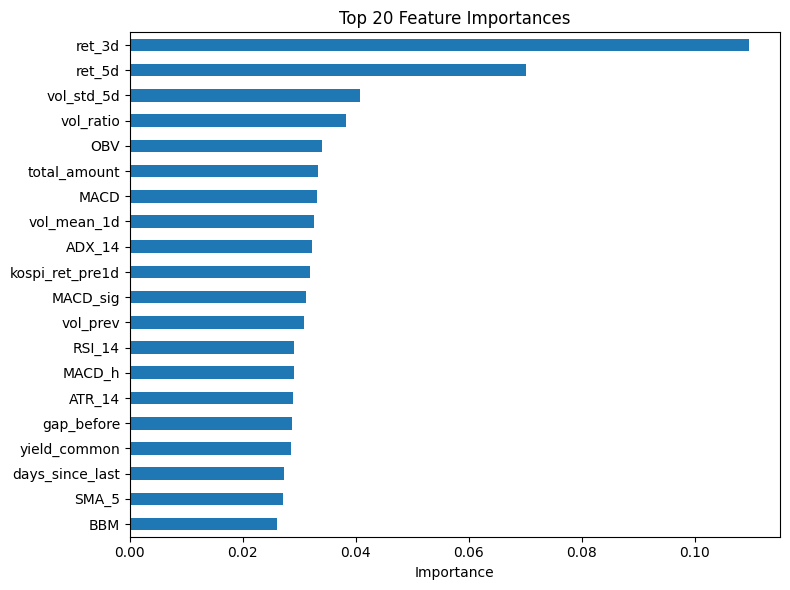

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(clf.feature_importances_, index=X_train.columns)
top_imp = importances.sort_values(ascending=False).head(20)
print("=== 상위 20개 중요 피처 ===")
for feat, imp in top_imp.items():
    print(f"{feat:20s} : {imp:.4f}")

plt.figure(figsize=(8, 6))
top_imp.plot.barh()
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [11]:
import os
import pandas as pd
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing   import OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline

# ── 1. 데이터 로드 & 누수 피처 제거 ─────────────────────────────────────────
BASE   = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
FP     = os.path.join(BASE, "module_datasets", "classification.csv")

df = pd.read_csv(FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})

# 제거할 누수 피처들
leak_features = ["ret_3d", "ret_5d", "volatility_5d", "volume_ratio"]  
df = df.drop(columns=[c for c in leak_features if c in df.columns])

# 타깃과 피처 분리
y = df["up_1d"]
X = df.drop(columns=["corp_name","stock_code","rcept_dt","up_1d"])

# ── 2. 범주형과 수치형 분리 ─────────────────────────────────────────────
cat_cols = [c for c in ["sector","day_of_week"] if c in X.columns]

# ── 3. ColumnTransformer에 handle_unknown 추가 ───────────────────────────
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(
        drop="first", 
        sparse_output=False, 
        handle_unknown="ignore"
    ), cat_cols),
], remainder="passthrough")

# ── 4. 파이프라인 정의 ─────────────────────────────────────────────────
clf = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", clf)
])

# ── 5. 5-폴드 교차검증 평가 ────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "AUC": "roc_auc",
    "F1":  "f1"
}

cv_res = cross_validate(
    pipe, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# ── 6. 결과 출력 ──────────────────────────────────────────────────────
print("5-폴드 교차검증 결과:")
for metric in scoring:
    scores = cv_res[f"test_{metric}"]
    print(f"  {metric:>4} : {scores.mean():.4f} ± {scores.std():.4f}")

5-폴드 교차검증 결과:
   AUC : 0.6801 ± 0.0331
    F1 : 0.4958 ± 0.0498


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

In [12]:
# 설치: 
# pip install sentence-transformers

from sentence_transformers import SentenceTransformer
import pandas as pd
import os
from tqdm.auto import tqdm
import numpy as np

BASE       = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
JSONL_PATH = os.path.join(BASE, "dividend_with_text.jsonl")  # 혹은 csv
EMB_PATH    = os.path.join(BASE, "module_datasets", "text_embeddings.npy")
IDX_PATH    = os.path.join(BASE, "module_datasets", "text_index.pkl")

# 1) 모델 로드
#    • all-MiniLM-L6-v2: 작고 빠른 범용 모델
#    • monologg/koelectra-base-v3-discriminator: 한국어 특화
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# 2) 텍스트 불러오기
#    JSONL에 {"text": ...} 형태로 들어있다고 가정
texts = []
ids   = []  # 나중에 원본 행 매핑용
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        rec = pd.read_json(line, typ="series")
        texts.append(rec["html"])
        ids.append((rec["stock_code"], rec["rcept_dt"]))

# 3) 배치 임베딩 생성
batch_size = 64
embs = []
for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
    batch = texts[i : i+batch_size]
    embs.append(model.encode(batch, show_progress_bar=False))
embs = np.vstack(embs)

# 4) 저장
np.save(EMB_PATH, embs)  # (N_events, dim) array
import pickle
with open(IDX_PATH, "wb") as f:
    pickle.dump(ids, f)

print(f"✅ 임베딩 저장 → {EMB_PATH} (shape={embs.shape})")

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rec = pd.read_json(line, typ="series")
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_27830/1217156165.py:27: FutureWarning: Passing literal json to

Embedding:   0%|                                                                      | 0/426 [00:00<?, ?it/s]

Embedding:   0%|▏                                                             | 1/426 [00:00<04:28,  1.59it/s]

Embedding:   0%|▎                                                             | 2/426 [00:00<03:17,  2.14it/s]

Embedding:   1%|▍                                                             | 3/426 [00:01<03:00,  2.35it/s]

Embedding:   1%|▌                                                             | 4/426 [00:01<02:50,  2.48it/s]

Embedding:   1%|▋                                                             | 5/426 [00:02<02:42,  2.59it/s]

Embedding:   1%|▊                                                             | 6/426 [00:02<02:37,  2.67it/s]

Embedding:   2%|█                                                             | 7/426 [00:02<02:33,  2.74it/s]

Embedding:   2%|█▏                                                            | 8/426 [00:03<02:31,  2.76it/s]

Embedding:   2%|█▎                                                            | 9/426 [00:03<02:30,  2.77it/s]

Embedding:   2%|█▍                                                           | 10/426 [00:03<02:28,  2.80it/s]

Embedding:   3%|█▌                                                           | 11/426 [00:04<02:27,  2.81it/s]

Embedding:   3%|█▋                                                           | 12/426 [00:04<02:29,  2.77it/s]

Embedding:   3%|█▊                                                           | 13/426 [00:04<02:26,  2.82it/s]

Embedding:   3%|██                                                           | 14/426 [00:05<02:25,  2.82it/s]

Embedding:   4%|██▏                                                          | 15/426 [00:05<02:24,  2.84it/s]

Embedding:   4%|██▎                                                          | 16/426 [00:05<02:25,  2.82it/s]

Embedding:   4%|██▍                                                          | 17/426 [00:06<02:25,  2.82it/s]

Embedding:   4%|██▌                                                          | 18/426 [00:06<02:23,  2.84it/s]

Embedding:   4%|██▋                                                          | 19/426 [00:07<02:22,  2.86it/s]

Embedding:   5%|██▊                                                          | 20/426 [00:07<02:21,  2.86it/s]

Embedding:   5%|███                                                          | 21/426 [00:07<02:21,  2.87it/s]

Embedding:   5%|███▏                                                         | 22/426 [00:08<02:22,  2.84it/s]

Embedding:   5%|███▎                                                         | 23/426 [00:08<02:22,  2.83it/s]

Embedding:   6%|███▍                                                         | 24/426 [00:08<02:21,  2.84it/s]

Embedding:   6%|███▌                                                         | 25/426 [00:09<02:21,  2.82it/s]

Embedding:   6%|███▋                                                         | 26/426 [00:09<02:25,  2.74it/s]

Embedding:   6%|███▊                                                         | 27/426 [00:09<02:28,  2.69it/s]

Embedding:   7%|████                                                         | 28/426 [00:10<02:30,  2.65it/s]

Embedding:   7%|████▏                                                        | 29/426 [00:10<02:32,  2.60it/s]

Embedding:   7%|████▎                                                        | 30/426 [00:11<02:30,  2.63it/s]

Embedding:   7%|████▍                                                        | 31/426 [00:11<02:28,  2.66it/s]

Embedding:   8%|████▌                                                        | 32/426 [00:11<02:26,  2.70it/s]

Embedding:   8%|████▋                                                        | 33/426 [00:12<02:27,  2.66it/s]

Embedding:   8%|████▊                                                        | 34/426 [00:12<02:24,  2.71it/s]

Embedding:   8%|█████                                                        | 35/426 [00:12<02:22,  2.74it/s]

Embedding:   8%|█████▏                                                       | 36/426 [00:13<02:21,  2.76it/s]

Embedding:   9%|█████▎                                                       | 37/426 [00:13<02:19,  2.79it/s]

Embedding:   9%|█████▍                                                       | 38/426 [00:13<02:17,  2.83it/s]

Embedding:   9%|█████▌                                                       | 39/426 [00:14<02:16,  2.83it/s]

Embedding:   9%|█████▋                                                       | 40/426 [00:14<02:16,  2.83it/s]

Embedding:  10%|█████▊                                                       | 41/426 [00:14<02:13,  2.88it/s]

Embedding:  10%|██████                                                       | 42/426 [00:15<02:14,  2.86it/s]

Embedding:  10%|██████▏                                                      | 43/426 [00:15<02:13,  2.87it/s]

Embedding:  10%|██████▎                                                      | 44/426 [00:16<02:12,  2.88it/s]

Embedding:  11%|██████▍                                                      | 45/426 [00:16<02:13,  2.85it/s]

Embedding:  11%|██████▌                                                      | 46/426 [00:16<02:13,  2.84it/s]

Embedding:  11%|██████▋                                                      | 47/426 [00:17<02:12,  2.85it/s]

Embedding:  11%|██████▊                                                      | 48/426 [00:17<02:12,  2.85it/s]

Embedding:  12%|███████                                                      | 49/426 [00:17<02:11,  2.88it/s]

Embedding:  12%|███████▏                                                     | 50/426 [00:18<02:10,  2.89it/s]

Embedding:  12%|███████▎                                                     | 51/426 [00:18<02:08,  2.91it/s]

Embedding:  12%|███████▍                                                     | 52/426 [00:18<02:07,  2.94it/s]

Embedding:  12%|███████▌                                                     | 53/426 [00:19<02:08,  2.89it/s]

Embedding:  13%|███████▋                                                     | 54/426 [00:19<02:11,  2.82it/s]

Embedding:  13%|███████▉                                                     | 55/426 [00:19<02:09,  2.86it/s]

Embedding:  13%|████████                                                     | 56/426 [00:20<02:10,  2.85it/s]

Embedding:  13%|████████▏                                                    | 57/426 [00:20<02:10,  2.83it/s]

Embedding:  14%|████████▎                                                    | 58/426 [00:20<02:10,  2.82it/s]

Embedding:  14%|████████▍                                                    | 59/426 [00:21<02:09,  2.84it/s]

Embedding:  14%|████████▌                                                    | 60/426 [00:21<02:08,  2.84it/s]

Embedding:  14%|████████▋                                                    | 61/426 [00:21<02:07,  2.85it/s]

Embedding:  15%|████████▉                                                    | 62/426 [00:22<02:07,  2.85it/s]

Embedding:  15%|█████████                                                    | 63/426 [00:22<02:07,  2.84it/s]

Embedding:  15%|█████████▏                                                   | 64/426 [00:23<02:06,  2.87it/s]

Embedding:  15%|█████████▎                                                   | 65/426 [00:23<02:07,  2.84it/s]

Embedding:  15%|█████████▍                                                   | 66/426 [00:23<02:06,  2.85it/s]

Embedding:  16%|█████████▌                                                   | 67/426 [00:24<02:06,  2.84it/s]

Embedding:  16%|█████████▋                                                   | 68/426 [00:24<02:07,  2.81it/s]

Embedding:  16%|█████████▉                                                   | 69/426 [00:24<02:07,  2.80it/s]

Embedding:  16%|██████████                                                   | 70/426 [00:25<02:05,  2.84it/s]

Embedding:  17%|██████████▏                                                  | 71/426 [00:25<02:03,  2.87it/s]

Embedding:  17%|██████████▎                                                  | 72/426 [00:25<02:03,  2.86it/s]

Embedding:  17%|██████████▍                                                  | 73/426 [00:26<02:03,  2.86it/s]

Embedding:  17%|██████████▌                                                  | 74/426 [00:26<02:04,  2.84it/s]

Embedding:  18%|██████████▋                                                  | 75/426 [00:26<02:02,  2.87it/s]

Embedding:  18%|██████████▉                                                  | 76/426 [00:27<02:02,  2.85it/s]

Embedding:  18%|███████████                                                  | 77/426 [00:27<02:02,  2.86it/s]

Embedding:  18%|███████████▏                                                 | 78/426 [00:27<02:01,  2.87it/s]

Embedding:  19%|███████████▎                                                 | 79/426 [00:28<02:00,  2.88it/s]

Embedding:  19%|███████████▍                                                 | 80/426 [00:28<02:00,  2.87it/s]

Embedding:  19%|███████████▌                                                 | 81/426 [00:28<01:59,  2.88it/s]

Embedding:  19%|███████████▋                                                 | 82/426 [00:29<02:00,  2.86it/s]

Embedding:  19%|███████████▉                                                 | 83/426 [00:29<01:59,  2.87it/s]

Embedding:  20%|████████████                                                 | 84/426 [00:30<01:59,  2.87it/s]

Embedding:  20%|████████████▏                                                | 85/426 [00:30<02:00,  2.83it/s]

Embedding:  20%|████████████▎                                                | 86/426 [00:30<02:00,  2.82it/s]

Embedding:  20%|████████████▍                                                | 87/426 [00:31<02:00,  2.82it/s]

Embedding:  21%|████████████▌                                                | 88/426 [00:31<01:59,  2.82it/s]

Embedding:  21%|████████████▋                                                | 89/426 [00:31<01:57,  2.86it/s]

Embedding:  21%|████████████▉                                                | 90/426 [00:32<01:57,  2.87it/s]

Embedding:  21%|█████████████                                                | 91/426 [00:32<01:56,  2.87it/s]

Embedding:  22%|█████████████▏                                               | 92/426 [00:32<01:56,  2.86it/s]

Embedding:  22%|█████████████▎                                               | 93/426 [00:33<01:56,  2.87it/s]

Embedding:  22%|█████████████▍                                               | 94/426 [00:33<01:56,  2.86it/s]

Embedding:  22%|█████████████▌                                               | 95/426 [00:33<01:56,  2.85it/s]

Embedding:  23%|█████████████▋                                               | 96/426 [00:34<01:56,  2.84it/s]

Embedding:  23%|█████████████▉                                               | 97/426 [00:34<01:55,  2.85it/s]

Embedding:  23%|██████████████                                               | 98/426 [00:34<01:54,  2.86it/s]

Embedding:  23%|██████████████▏                                              | 99/426 [00:35<01:54,  2.86it/s]

Embedding:  23%|██████████████                                              | 100/426 [00:35<01:54,  2.84it/s]

Embedding:  24%|██████████████▏                                             | 101/426 [00:36<01:54,  2.84it/s]

Embedding:  24%|██████████████▎                                             | 102/426 [00:36<01:55,  2.79it/s]

Embedding:  24%|██████████████▌                                             | 103/426 [00:36<01:56,  2.76it/s]

Embedding:  24%|██████████████▋                                             | 104/426 [00:37<01:55,  2.78it/s]

Embedding:  25%|██████████████▊                                             | 105/426 [00:37<01:56,  2.76it/s]

Embedding:  25%|██████████████▉                                             | 106/426 [00:37<01:53,  2.82it/s]

Embedding:  25%|███████████████                                             | 107/426 [00:38<01:51,  2.86it/s]

Embedding:  25%|███████████████▏                                            | 108/426 [00:38<01:52,  2.84it/s]

Embedding:  26%|███████████████▎                                            | 109/426 [00:38<01:51,  2.84it/s]

Embedding:  26%|███████████████▍                                            | 110/426 [00:39<01:55,  2.75it/s]

Embedding:  26%|███████████████▋                                            | 111/426 [00:39<01:53,  2.77it/s]

Embedding:  26%|███████████████▊                                            | 112/426 [00:39<01:53,  2.78it/s]

Embedding:  27%|███████████████▉                                            | 113/426 [00:40<01:51,  2.80it/s]

Embedding:  27%|████████████████                                            | 114/426 [00:40<01:52,  2.77it/s]

Embedding:  27%|████████████████▏                                           | 115/426 [00:41<01:51,  2.80it/s]

Embedding:  27%|████████████████▎                                           | 116/426 [00:41<01:50,  2.81it/s]

Embedding:  27%|████████████████▍                                           | 117/426 [00:41<01:49,  2.82it/s]

Embedding:  28%|████████████████▌                                           | 118/426 [00:42<01:49,  2.80it/s]

Embedding:  28%|████████████████▊                                           | 119/426 [00:42<01:51,  2.75it/s]

Embedding:  28%|████████████████▉                                           | 120/426 [00:42<01:50,  2.78it/s]

Embedding:  28%|█████████████████                                           | 121/426 [00:43<01:48,  2.81it/s]

Embedding:  29%|█████████████████▏                                          | 122/426 [00:43<01:47,  2.83it/s]

Embedding:  29%|█████████████████▎                                          | 123/426 [00:43<01:48,  2.80it/s]

Embedding:  29%|█████████████████▍                                          | 124/426 [00:44<01:47,  2.81it/s]

Embedding:  29%|█████████████████▌                                          | 125/426 [00:44<01:47,  2.79it/s]

Embedding:  30%|█████████████████▋                                          | 126/426 [00:44<01:47,  2.79it/s]

Embedding:  30%|█████████████████▉                                          | 127/426 [00:45<01:50,  2.70it/s]

Embedding:  30%|██████████████████                                          | 128/426 [00:45<01:48,  2.74it/s]

Embedding:  30%|██████████████████▏                                         | 129/426 [00:46<01:46,  2.78it/s]

Embedding:  31%|██████████████████▎                                         | 130/426 [00:46<01:45,  2.81it/s]

Embedding:  31%|██████████████████▍                                         | 131/426 [00:46<01:44,  2.81it/s]

Embedding:  31%|██████████████████▌                                         | 132/426 [00:47<01:46,  2.76it/s]

Embedding:  31%|██████████████████▋                                         | 133/426 [00:47<01:46,  2.76it/s]

Embedding:  31%|██████████████████▊                                         | 134/426 [00:47<01:45,  2.76it/s]

Embedding:  32%|███████████████████                                         | 135/426 [00:48<01:44,  2.78it/s]

Embedding:  32%|███████████████████▏                                        | 136/426 [00:48<01:43,  2.79it/s]

Embedding:  32%|███████████████████▎                                        | 137/426 [00:48<01:42,  2.81it/s]

Embedding:  32%|███████████████████▍                                        | 138/426 [00:49<01:41,  2.85it/s]

Embedding:  33%|███████████████████▌                                        | 139/426 [00:49<01:41,  2.84it/s]

Embedding:  33%|███████████████████▋                                        | 140/426 [00:49<01:39,  2.86it/s]

Embedding:  33%|███████████████████▊                                        | 141/426 [00:50<01:39,  2.86it/s]

Embedding:  33%|████████████████████                                        | 142/426 [00:50<01:39,  2.86it/s]

Embedding:  34%|████████████████████▏                                       | 143/426 [00:51<01:39,  2.84it/s]

Embedding:  34%|████████████████████▎                                       | 144/426 [00:51<01:39,  2.83it/s]

Embedding:  34%|████████████████████▍                                       | 145/426 [00:51<01:39,  2.82it/s]

Embedding:  34%|████████████████████▌                                       | 146/426 [00:52<01:39,  2.81it/s]

Embedding:  35%|████████████████████▋                                       | 147/426 [00:52<01:40,  2.77it/s]

Embedding:  35%|████████████████████▊                                       | 148/426 [00:52<01:40,  2.76it/s]

Embedding:  35%|████████████████████▉                                       | 149/426 [00:53<01:39,  2.78it/s]

Embedding:  35%|█████████████████████▏                                      | 150/426 [00:53<01:40,  2.75it/s]

Embedding:  35%|█████████████████████▎                                      | 151/426 [00:53<01:38,  2.80it/s]

Embedding:  36%|█████████████████████▍                                      | 152/426 [00:54<01:38,  2.79it/s]

Embedding:  36%|█████████████████████▌                                      | 153/426 [00:54<01:37,  2.80it/s]

Embedding:  36%|█████████████████████▋                                      | 154/426 [00:54<01:36,  2.82it/s]

Embedding:  36%|█████████████████████▊                                      | 155/426 [00:55<01:36,  2.80it/s]

Embedding:  37%|█████████████████████▉                                      | 156/426 [00:55<01:36,  2.79it/s]

Embedding:  37%|██████████████████████                                      | 157/426 [00:56<01:36,  2.80it/s]

Embedding:  37%|██████████████████████▎                                     | 158/426 [00:56<01:35,  2.81it/s]

Embedding:  37%|██████████████████████▍                                     | 159/426 [00:56<01:35,  2.81it/s]

Embedding:  38%|██████████████████████▌                                     | 160/426 [00:57<01:34,  2.80it/s]

Embedding:  38%|██████████████████████▋                                     | 161/426 [00:57<01:34,  2.80it/s]

Embedding:  38%|██████████████████████▊                                     | 162/426 [00:57<01:35,  2.77it/s]

Embedding:  38%|██████████████████████▉                                     | 163/426 [00:58<01:34,  2.79it/s]

Embedding:  38%|███████████████████████                                     | 164/426 [00:58<01:35,  2.76it/s]

Embedding:  39%|███████████████████████▏                                    | 165/426 [00:58<01:33,  2.78it/s]

Embedding:  39%|███████████████████████▍                                    | 166/426 [00:59<01:32,  2.81it/s]

Embedding:  39%|███████████████████████▌                                    | 167/426 [00:59<01:31,  2.83it/s]

Embedding:  39%|███████████████████████▋                                    | 168/426 [00:59<01:31,  2.83it/s]

Embedding:  40%|███████████████████████▊                                    | 169/426 [01:00<01:32,  2.79it/s]

Embedding:  40%|███████████████████████▉                                    | 170/426 [01:00<01:32,  2.78it/s]

Embedding:  40%|████████████████████████                                    | 171/426 [01:01<01:30,  2.80it/s]

Embedding:  40%|████████████████████████▏                                   | 172/426 [01:01<01:31,  2.79it/s]

Embedding:  41%|████████████████████████▎                                   | 173/426 [01:01<01:31,  2.76it/s]

Embedding:  41%|████████████████████████▌                                   | 174/426 [01:02<01:31,  2.76it/s]

Embedding:  41%|████████████████████████▋                                   | 175/426 [01:02<01:30,  2.77it/s]

Embedding:  41%|████████████████████████▊                                   | 176/426 [01:02<01:31,  2.73it/s]

Embedding:  42%|████████████████████████▉                                   | 177/426 [01:03<01:31,  2.73it/s]

Embedding:  42%|█████████████████████████                                   | 178/426 [01:03<01:31,  2.72it/s]

Embedding:  42%|█████████████████████████▏                                  | 179/426 [01:03<01:30,  2.73it/s]

Embedding:  42%|█████████████████████████▎                                  | 180/426 [01:04<01:31,  2.70it/s]

Embedding:  42%|█████████████████████████▍                                  | 181/426 [01:04<01:29,  2.73it/s]

Embedding:  43%|█████████████████████████▋                                  | 182/426 [01:05<01:29,  2.72it/s]

Embedding:  43%|█████████████████████████▊                                  | 183/426 [01:05<01:28,  2.75it/s]

Embedding:  43%|█████████████████████████▉                                  | 184/426 [01:05<01:28,  2.74it/s]

Embedding:  43%|██████████████████████████                                  | 185/426 [01:06<01:27,  2.76it/s]

Embedding:  44%|██████████████████████████▏                                 | 186/426 [01:06<01:27,  2.75it/s]

Embedding:  44%|██████████████████████████▎                                 | 187/426 [01:06<01:26,  2.75it/s]

Embedding:  44%|██████████████████████████▍                                 | 188/426 [01:07<01:25,  2.77it/s]

Embedding:  44%|██████████████████████████▌                                 | 189/426 [01:07<01:25,  2.77it/s]

Embedding:  45%|██████████████████████████▊                                 | 190/426 [01:07<01:25,  2.77it/s]

Embedding:  45%|██████████████████████████▉                                 | 191/426 [01:08<01:24,  2.78it/s]

Embedding:  45%|███████████████████████████                                 | 192/426 [01:08<01:23,  2.79it/s]

Embedding:  45%|███████████████████████████▏                                | 193/426 [01:09<01:23,  2.80it/s]

Embedding:  46%|███████████████████████████▎                                | 194/426 [01:09<01:22,  2.80it/s]

Embedding:  46%|███████████████████████████▍                                | 195/426 [01:09<01:22,  2.80it/s]

Embedding:  46%|███████████████████████████▌                                | 196/426 [01:10<01:21,  2.81it/s]

Embedding:  46%|███████████████████████████▋                                | 197/426 [01:10<01:23,  2.74it/s]

Embedding:  46%|███████████████████████████▉                                | 198/426 [01:10<01:24,  2.69it/s]

Embedding:  47%|████████████████████████████                                | 199/426 [01:11<01:22,  2.74it/s]

Embedding:  47%|████████████████████████████▏                               | 200/426 [01:11<01:23,  2.72it/s]

Embedding:  47%|████████████████████████████▎                               | 201/426 [01:11<01:21,  2.75it/s]

Embedding:  47%|████████████████████████████▍                               | 202/426 [01:12<01:21,  2.75it/s]

Embedding:  48%|████████████████████████████▌                               | 203/426 [01:12<01:21,  2.74it/s]

Embedding:  48%|████████████████████████████▋                               | 204/426 [01:13<01:20,  2.77it/s]

Embedding:  48%|████████████████████████████▊                               | 205/426 [01:13<01:20,  2.75it/s]

Embedding:  48%|█████████████████████████████                               | 206/426 [01:13<01:19,  2.76it/s]

Embedding:  49%|█████████████████████████████▏                              | 207/426 [01:14<01:19,  2.76it/s]

Embedding:  49%|█████████████████████████████▎                              | 208/426 [01:14<01:18,  2.77it/s]

Embedding:  49%|█████████████████████████████▍                              | 209/426 [01:14<01:17,  2.79it/s]

Embedding:  49%|█████████████████████████████▌                              | 210/426 [01:15<01:17,  2.77it/s]

Embedding:  50%|█████████████████████████████▋                              | 211/426 [01:15<01:17,  2.77it/s]

Embedding:  50%|█████████████████████████████▊                              | 212/426 [01:15<01:16,  2.80it/s]

Embedding:  50%|██████████████████████████████                              | 213/426 [01:16<01:16,  2.79it/s]

Embedding:  50%|██████████████████████████████▏                             | 214/426 [01:16<01:16,  2.78it/s]

Embedding:  50%|██████████████████████████████▎                             | 215/426 [01:17<01:15,  2.80it/s]

Embedding:  51%|██████████████████████████████▍                             | 216/426 [01:17<01:14,  2.81it/s]

Embedding:  51%|██████████████████████████████▌                             | 217/426 [01:17<01:15,  2.78it/s]

Embedding:  51%|██████████████████████████████▋                             | 218/426 [01:18<01:15,  2.76it/s]

Embedding:  51%|██████████████████████████████▊                             | 219/426 [01:18<01:14,  2.76it/s]

Embedding:  52%|██████████████████████████████▉                             | 220/426 [01:18<01:15,  2.73it/s]

Embedding:  52%|███████████████████████████████▏                            | 221/426 [01:19<01:14,  2.74it/s]

Embedding:  52%|███████████████████████████████▎                            | 222/426 [01:19<01:14,  2.75it/s]

Embedding:  52%|███████████████████████████████▍                            | 223/426 [01:19<01:13,  2.76it/s]

Embedding:  53%|███████████████████████████████▌                            | 224/426 [01:20<01:13,  2.76it/s]

Embedding:  53%|███████████████████████████████▋                            | 225/426 [01:20<01:12,  2.76it/s]

Embedding:  53%|███████████████████████████████▊                            | 226/426 [01:21<01:12,  2.75it/s]

Embedding:  53%|███████████████████████████████▉                            | 227/426 [01:21<01:11,  2.76it/s]

Embedding:  54%|████████████████████████████████                            | 228/426 [01:21<01:11,  2.76it/s]

Embedding:  54%|████████████████████████████████▎                           | 229/426 [01:22<01:11,  2.74it/s]

Embedding:  54%|████████████████████████████████▍                           | 230/426 [01:22<01:12,  2.70it/s]

Embedding:  54%|████████████████████████████████▌                           | 231/426 [01:22<01:12,  2.68it/s]

Embedding:  54%|████████████████████████████████▋                           | 232/426 [01:23<01:15,  2.57it/s]

Embedding:  55%|████████████████████████████████▊                           | 233/426 [01:23<01:14,  2.58it/s]

Embedding:  55%|████████████████████████████████▉                           | 234/426 [01:24<01:13,  2.62it/s]

Embedding:  55%|█████████████████████████████████                           | 235/426 [01:24<01:11,  2.67it/s]

Embedding:  55%|█████████████████████████████████▏                          | 236/426 [01:24<01:11,  2.66it/s]

Embedding:  56%|█████████████████████████████████▍                          | 237/426 [01:25<01:10,  2.69it/s]

Embedding:  56%|█████████████████████████████████▌                          | 238/426 [01:25<01:10,  2.67it/s]

Embedding:  56%|█████████████████████████████████▋                          | 239/426 [01:25<01:09,  2.68it/s]

Embedding:  56%|█████████████████████████████████▊                          | 240/426 [01:26<01:09,  2.68it/s]

Embedding:  57%|█████████████████████████████████▉                          | 241/426 [01:26<01:07,  2.72it/s]

Embedding:  57%|██████████████████████████████████                          | 242/426 [01:26<01:08,  2.69it/s]

Embedding:  57%|██████████████████████████████████▏                         | 243/426 [01:27<01:08,  2.68it/s]

Embedding:  57%|██████████████████████████████████▎                         | 244/426 [01:27<01:07,  2.71it/s]

Embedding:  58%|██████████████████████████████████▌                         | 245/426 [01:28<01:07,  2.70it/s]

Embedding:  58%|██████████████████████████████████▋                         | 246/426 [01:28<01:05,  2.73it/s]

Embedding:  58%|██████████████████████████████████▊                         | 247/426 [01:28<01:05,  2.74it/s]

Embedding:  58%|██████████████████████████████████▉                         | 248/426 [01:29<01:04,  2.78it/s]

Embedding:  58%|███████████████████████████████████                         | 249/426 [01:29<01:03,  2.79it/s]

Embedding:  59%|███████████████████████████████████▏                        | 250/426 [01:29<01:03,  2.78it/s]

Embedding:  59%|███████████████████████████████████▎                        | 251/426 [01:30<01:02,  2.79it/s]

Embedding:  59%|███████████████████████████████████▍                        | 252/426 [01:30<01:02,  2.79it/s]

Embedding:  59%|███████████████████████████████████▋                        | 253/426 [01:30<01:02,  2.75it/s]

Embedding:  60%|███████████████████████████████████▊                        | 254/426 [01:31<01:02,  2.76it/s]

Embedding:  60%|███████████████████████████████████▉                        | 255/426 [01:31<01:01,  2.77it/s]

Embedding:  60%|████████████████████████████████████                        | 256/426 [01:32<01:01,  2.77it/s]

Embedding:  60%|████████████████████████████████████▏                       | 257/426 [01:32<01:00,  2.79it/s]

Embedding:  61%|████████████████████████████████████▎                       | 258/426 [01:32<00:59,  2.81it/s]

Embedding:  61%|████████████████████████████████████▍                       | 259/426 [01:33<00:59,  2.81it/s]

Embedding:  61%|████████████████████████████████████▌                       | 260/426 [01:33<00:59,  2.79it/s]

Embedding:  61%|████████████████████████████████████▊                       | 261/426 [01:33<00:59,  2.78it/s]

Embedding:  62%|████████████████████████████████████▉                       | 262/426 [01:34<01:01,  2.68it/s]

Embedding:  62%|█████████████████████████████████████                       | 263/426 [01:34<01:01,  2.63it/s]

Embedding:  62%|█████████████████████████████████████▏                      | 264/426 [01:35<01:03,  2.57it/s]

Embedding:  62%|█████████████████████████████████████▎                      | 265/426 [01:35<01:02,  2.56it/s]

Embedding:  62%|█████████████████████████████████████▍                      | 266/426 [01:35<01:01,  2.59it/s]

Embedding:  63%|█████████████████████████████████████▌                      | 267/426 [01:36<01:00,  2.63it/s]

Embedding:  63%|█████████████████████████████████████▋                      | 268/426 [01:36<01:00,  2.61it/s]

Embedding:  63%|█████████████████████████████████████▉                      | 269/426 [01:36<01:00,  2.59it/s]

Embedding:  63%|██████████████████████████████████████                      | 270/426 [01:37<00:59,  2.64it/s]

Embedding:  64%|██████████████████████████████████████▏                     | 271/426 [01:37<00:58,  2.64it/s]

Embedding:  64%|██████████████████████████████████████▎                     | 272/426 [01:38<00:57,  2.67it/s]

Embedding:  64%|██████████████████████████████████████▍                     | 273/426 [01:38<00:56,  2.70it/s]

Embedding:  64%|██████████████████████████████████████▌                     | 274/426 [01:38<00:56,  2.70it/s]

Embedding:  65%|██████████████████████████████████████▋                     | 275/426 [01:39<00:55,  2.72it/s]

Embedding:  65%|██████████████████████████████████████▊                     | 276/426 [01:39<00:55,  2.68it/s]

Embedding:  65%|███████████████████████████████████████                     | 277/426 [01:39<00:55,  2.68it/s]

Embedding:  65%|███████████████████████████████████████▏                    | 278/426 [01:40<00:54,  2.73it/s]

Embedding:  65%|███████████████████████████████████████▎                    | 279/426 [01:40<00:54,  2.71it/s]

Embedding:  66%|███████████████████████████████████████▍                    | 280/426 [01:41<00:54,  2.70it/s]

Embedding:  66%|███████████████████████████████████████▌                    | 281/426 [01:41<00:53,  2.72it/s]

Embedding:  66%|███████████████████████████████████████▋                    | 282/426 [01:41<00:52,  2.72it/s]

Embedding:  66%|███████████████████████████████████████▊                    | 283/426 [01:42<00:53,  2.69it/s]

Embedding:  67%|████████████████████████████████████████                    | 284/426 [01:42<00:53,  2.68it/s]

Embedding:  67%|████████████████████████████████████████▏                   | 285/426 [01:42<00:52,  2.69it/s]

Embedding:  67%|████████████████████████████████████████▎                   | 286/426 [01:43<00:51,  2.71it/s]

Embedding:  67%|████████████████████████████████████████▍                   | 287/426 [01:43<00:51,  2.72it/s]

Embedding:  68%|████████████████████████████████████████▌                   | 288/426 [01:43<00:50,  2.71it/s]

Embedding:  68%|████████████████████████████████████████▋                   | 289/426 [01:44<00:50,  2.71it/s]

Embedding:  68%|████████████████████████████████████████▊                   | 290/426 [01:44<00:50,  2.72it/s]

Embedding:  68%|████████████████████████████████████████▉                   | 291/426 [01:45<00:49,  2.71it/s]

Embedding:  69%|█████████████████████████████████████████▏                  | 292/426 [01:45<00:49,  2.73it/s]

Embedding:  69%|█████████████████████████████████████████▎                  | 293/426 [01:45<00:48,  2.74it/s]

Embedding:  69%|█████████████████████████████████████████▍                  | 294/426 [01:46<00:48,  2.72it/s]

Embedding:  69%|█████████████████████████████████████████▌                  | 295/426 [01:46<00:48,  2.70it/s]

Embedding:  69%|█████████████████████████████████████████▋                  | 296/426 [01:46<00:47,  2.74it/s]

Embedding:  70%|█████████████████████████████████████████▊                  | 297/426 [01:47<00:47,  2.69it/s]

Embedding:  70%|█████████████████████████████████████████▉                  | 298/426 [01:47<00:47,  2.69it/s]

Embedding:  70%|██████████████████████████████████████████                  | 299/426 [01:48<00:47,  2.68it/s]

Embedding:  70%|██████████████████████████████████████████▎                 | 300/426 [01:48<00:46,  2.72it/s]

Embedding:  71%|██████████████████████████████████████████▍                 | 301/426 [01:48<00:46,  2.71it/s]

Embedding:  71%|██████████████████████████████████████████▌                 | 302/426 [01:49<00:46,  2.69it/s]

Embedding:  71%|██████████████████████████████████████████▋                 | 303/426 [01:49<00:45,  2.70it/s]

Embedding:  71%|██████████████████████████████████████████▊                 | 304/426 [01:49<00:45,  2.70it/s]

Embedding:  72%|██████████████████████████████████████████▉                 | 305/426 [01:50<00:44,  2.71it/s]

Embedding:  72%|███████████████████████████████████████████                 | 306/426 [01:50<00:44,  2.71it/s]

Embedding:  72%|███████████████████████████████████████████▏                | 307/426 [01:51<00:44,  2.68it/s]

Embedding:  72%|███████████████████████████████████████████▍                | 308/426 [01:51<00:43,  2.70it/s]

Embedding:  73%|███████████████████████████████████████████▌                | 309/426 [01:51<00:43,  2.71it/s]

Embedding:  73%|███████████████████████████████████████████▋                | 310/426 [01:52<00:42,  2.72it/s]

Embedding:  73%|███████████████████████████████████████████▊                | 311/426 [01:52<00:42,  2.72it/s]

Embedding:  73%|███████████████████████████████████████████▉                | 312/426 [01:52<00:41,  2.72it/s]

Embedding:  73%|████████████████████████████████████████████                | 313/426 [01:53<00:41,  2.70it/s]

Embedding:  74%|████████████████████████████████████████████▏               | 314/426 [01:53<00:41,  2.68it/s]

Embedding:  74%|████████████████████████████████████████████▎               | 315/426 [01:53<00:41,  2.69it/s]

Embedding:  74%|████████████████████████████████████████████▌               | 316/426 [01:54<00:40,  2.69it/s]

Embedding:  74%|████████████████████████████████████████████▋               | 317/426 [01:54<00:40,  2.70it/s]

Embedding:  75%|████████████████████████████████████████████▊               | 318/426 [01:55<00:40,  2.69it/s]

Embedding:  75%|████████████████████████████████████████████▉               | 319/426 [01:55<00:39,  2.71it/s]

Embedding:  75%|█████████████████████████████████████████████               | 320/426 [01:55<00:39,  2.66it/s]

Embedding:  75%|█████████████████████████████████████████████▏              | 321/426 [01:56<00:39,  2.67it/s]

Embedding:  76%|█████████████████████████████████████████████▎              | 322/426 [01:56<00:38,  2.69it/s]

Embedding:  76%|█████████████████████████████████████████████▍              | 323/426 [01:56<00:38,  2.68it/s]

Embedding:  76%|█████████████████████████████████████████████▋              | 324/426 [01:57<00:37,  2.69it/s]

Embedding:  76%|█████████████████████████████████████████████▊              | 325/426 [01:57<00:37,  2.69it/s]

Embedding:  77%|█████████████████████████████████████████████▉              | 326/426 [01:58<00:37,  2.70it/s]

Embedding:  77%|██████████████████████████████████████████████              | 327/426 [01:58<00:36,  2.71it/s]

Embedding:  77%|██████████████████████████████████████████████▏             | 328/426 [01:58<00:36,  2.70it/s]

Embedding:  77%|██████████████████████████████████████████████▎             | 329/426 [01:59<00:35,  2.71it/s]

Embedding:  77%|██████████████████████████████████████████████▍             | 330/426 [01:59<00:35,  2.68it/s]

Embedding:  78%|██████████████████████████████████████████████▌             | 331/426 [01:59<00:35,  2.67it/s]

Embedding:  78%|██████████████████████████████████████████████▊             | 332/426 [02:00<00:34,  2.70it/s]

Embedding:  78%|██████████████████████████████████████████████▉             | 333/426 [02:00<00:34,  2.72it/s]

Embedding:  78%|███████████████████████████████████████████████             | 334/426 [02:01<00:33,  2.72it/s]

Embedding:  79%|███████████████████████████████████████████████▏            | 335/426 [02:01<00:33,  2.71it/s]

Embedding:  79%|███████████████████████████████████████████████▎            | 336/426 [02:01<00:33,  2.71it/s]

Embedding:  79%|███████████████████████████████████████████████▍            | 337/426 [02:02<00:33,  2.70it/s]

Embedding:  79%|███████████████████████████████████████████████▌            | 338/426 [02:02<00:32,  2.69it/s]

Embedding:  80%|███████████████████████████████████████████████▋            | 339/426 [02:02<00:32,  2.69it/s]

Embedding:  80%|███████████████████████████████████████████████▉            | 340/426 [02:03<00:32,  2.68it/s]

Embedding:  80%|████████████████████████████████████████████████            | 341/426 [02:03<00:32,  2.64it/s]

Embedding:  80%|████████████████████████████████████████████████▏           | 342/426 [02:04<00:31,  2.66it/s]

Embedding:  81%|████████████████████████████████████████████████▎           | 343/426 [02:04<00:32,  2.56it/s]

Embedding:  81%|████████████████████████████████████████████████▍           | 344/426 [02:04<00:31,  2.60it/s]

Embedding:  81%|████████████████████████████████████████████████▌           | 345/426 [02:05<00:31,  2.59it/s]

Embedding:  81%|████████████████████████████████████████████████▋           | 346/426 [02:05<00:30,  2.60it/s]

Embedding:  81%|████████████████████████████████████████████████▊           | 347/426 [02:05<00:30,  2.61it/s]

Embedding:  82%|█████████████████████████████████████████████████           | 348/426 [02:06<00:29,  2.62it/s]

Embedding:  82%|█████████████████████████████████████████████████▏          | 349/426 [02:06<00:29,  2.65it/s]

Embedding:  82%|█████████████████████████████████████████████████▎          | 350/426 [02:07<00:28,  2.66it/s]

Embedding:  82%|█████████████████████████████████████████████████▍          | 351/426 [02:07<00:28,  2.65it/s]

Embedding:  83%|█████████████████████████████████████████████████▌          | 352/426 [02:07<00:28,  2.64it/s]

Embedding:  83%|█████████████████████████████████████████████████▋          | 353/426 [02:08<00:27,  2.64it/s]

Embedding:  83%|█████████████████████████████████████████████████▊          | 354/426 [02:08<00:27,  2.67it/s]

Embedding:  83%|██████████████████████████████████████████████████          | 355/426 [02:08<00:26,  2.65it/s]

Embedding:  84%|██████████████████████████████████████████████████▏         | 356/426 [02:09<00:26,  2.67it/s]

Embedding:  84%|██████████████████████████████████████████████████▎         | 357/426 [02:09<00:26,  2.56it/s]

Embedding:  84%|██████████████████████████████████████████████████▍         | 358/426 [02:10<00:26,  2.55it/s]

Embedding:  84%|██████████████████████████████████████████████████▌         | 359/426 [02:10<00:25,  2.60it/s]

Embedding:  85%|██████████████████████████████████████████████████▋         | 360/426 [02:10<00:25,  2.57it/s]

Embedding:  85%|██████████████████████████████████████████████████▊         | 361/426 [02:11<00:25,  2.58it/s]

Embedding:  85%|██████████████████████████████████████████████████▉         | 362/426 [02:11<00:24,  2.61it/s]

Embedding:  85%|███████████████████████████████████████████████████▏        | 363/426 [02:12<00:23,  2.66it/s]

Embedding:  85%|███████████████████████████████████████████████████▎        | 364/426 [02:12<00:23,  2.66it/s]

Embedding:  86%|███████████████████████████████████████████████████▍        | 365/426 [02:12<00:22,  2.66it/s]

Embedding:  86%|███████████████████████████████████████████████████▌        | 366/426 [02:13<00:22,  2.65it/s]

Embedding:  86%|███████████████████████████████████████████████████▋        | 367/426 [02:13<00:22,  2.67it/s]

Embedding:  86%|███████████████████████████████████████████████████▊        | 368/426 [02:13<00:21,  2.66it/s]

Embedding:  87%|███████████████████████████████████████████████████▉        | 369/426 [02:14<00:21,  2.68it/s]

Embedding:  87%|████████████████████████████████████████████████████        | 370/426 [02:14<00:20,  2.69it/s]

Embedding:  87%|████████████████████████████████████████████████████▎       | 371/426 [02:15<00:20,  2.70it/s]

Embedding:  87%|████████████████████████████████████████████████████▍       | 372/426 [02:15<00:20,  2.70it/s]

Embedding:  88%|████████████████████████████████████████████████████▌       | 373/426 [02:15<00:19,  2.73it/s]

Embedding:  88%|████████████████████████████████████████████████████▋       | 374/426 [02:16<00:19,  2.71it/s]

Embedding:  88%|████████████████████████████████████████████████████▊       | 375/426 [02:16<00:18,  2.69it/s]

Embedding:  88%|████████████████████████████████████████████████████▉       | 376/426 [02:16<00:18,  2.70it/s]

Embedding:  88%|█████████████████████████████████████████████████████       | 377/426 [02:17<00:18,  2.71it/s]

Embedding:  89%|█████████████████████████████████████████████████████▏      | 378/426 [02:17<00:17,  2.72it/s]

Embedding:  89%|█████████████████████████████████████████████████████▍      | 379/426 [02:17<00:17,  2.71it/s]

Embedding:  89%|█████████████████████████████████████████████████████▌      | 380/426 [02:18<00:17,  2.69it/s]

Embedding:  89%|█████████████████████████████████████████████████████▋      | 381/426 [02:18<00:17,  2.63it/s]

Embedding:  90%|█████████████████████████████████████████████████████▊      | 382/426 [02:19<00:16,  2.62it/s]

Embedding:  90%|█████████████████████████████████████████████████████▉      | 383/426 [02:19<00:16,  2.62it/s]

Embedding:  90%|██████████████████████████████████████████████████████      | 384/426 [02:19<00:15,  2.66it/s]

Embedding:  90%|██████████████████████████████████████████████████████▏     | 385/426 [02:20<00:15,  2.68it/s]

Embedding:  91%|██████████████████████████████████████████████████████▎     | 386/426 [02:20<00:14,  2.68it/s]

Embedding:  91%|██████████████████████████████████████████████████████▌     | 387/426 [02:20<00:14,  2.67it/s]

Embedding:  91%|██████████████████████████████████████████████████████▋     | 388/426 [02:21<00:14,  2.66it/s]

Embedding:  91%|██████████████████████████████████████████████████████▊     | 389/426 [02:21<00:13,  2.66it/s]

Embedding:  92%|██████████████████████████████████████████████████████▉     | 390/426 [02:22<00:13,  2.65it/s]

Embedding:  92%|███████████████████████████████████████████████████████     | 391/426 [02:22<00:13,  2.64it/s]

Embedding:  92%|███████████████████████████████████████████████████████▏    | 392/426 [02:22<00:12,  2.63it/s]

Embedding:  92%|███████████████████████████████████████████████████████▎    | 393/426 [02:23<00:12,  2.59it/s]

Embedding:  92%|███████████████████████████████████████████████████████▍    | 394/426 [02:23<00:12,  2.61it/s]

Embedding:  93%|███████████████████████████████████████████████████████▋    | 395/426 [02:24<00:11,  2.61it/s]

Embedding:  93%|███████████████████████████████████████████████████████▊    | 396/426 [02:24<00:11,  2.57it/s]

Embedding:  93%|███████████████████████████████████████████████████████▉    | 397/426 [02:24<00:11,  2.57it/s]

Embedding:  93%|████████████████████████████████████████████████████████    | 398/426 [02:25<00:10,  2.59it/s]

Embedding:  94%|████████████████████████████████████████████████████████▏   | 399/426 [02:25<00:10,  2.62it/s]

Embedding:  94%|████████████████████████████████████████████████████████▎   | 400/426 [02:25<00:09,  2.64it/s]

Embedding:  94%|████████████████████████████████████████████████████████▍   | 401/426 [02:26<00:09,  2.64it/s]

Embedding:  94%|████████████████████████████████████████████████████████▌   | 402/426 [02:26<00:09,  2.63it/s]

Embedding:  95%|████████████████████████████████████████████████████████▊   | 403/426 [02:27<00:08,  2.62it/s]

Embedding:  95%|████████████████████████████████████████████████████████▉   | 404/426 [02:27<00:08,  2.63it/s]

Embedding:  95%|█████████████████████████████████████████████████████████   | 405/426 [02:27<00:07,  2.64it/s]

Embedding:  95%|█████████████████████████████████████████████████████████▏  | 406/426 [02:28<00:07,  2.62it/s]

Embedding:  96%|█████████████████████████████████████████████████████████▎  | 407/426 [02:28<00:07,  2.62it/s]

Embedding:  96%|█████████████████████████████████████████████████████████▍  | 408/426 [02:29<00:06,  2.61it/s]

Embedding:  96%|█████████████████████████████████████████████████████████▌  | 409/426 [02:29<00:06,  2.61it/s]

Embedding:  96%|█████████████████████████████████████████████████████████▋  | 410/426 [02:29<00:06,  2.63it/s]

Embedding:  96%|█████████████████████████████████████████████████████████▉  | 411/426 [02:30<00:05,  2.64it/s]

Embedding:  97%|██████████████████████████████████████████████████████████  | 412/426 [02:30<00:05,  2.66it/s]

Embedding:  97%|██████████████████████████████████████████████████████████▏ | 413/426 [02:30<00:04,  2.67it/s]

Embedding:  97%|██████████████████████████████████████████████████████████▎ | 414/426 [02:31<00:04,  2.64it/s]

Embedding:  97%|██████████████████████████████████████████████████████████▍ | 415/426 [02:31<00:04,  2.64it/s]

Embedding:  98%|██████████████████████████████████████████████████████████▌ | 416/426 [02:32<00:03,  2.61it/s]

Embedding:  98%|██████████████████████████████████████████████████████████▋ | 417/426 [02:32<00:03,  2.64it/s]

Embedding:  98%|██████████████████████████████████████████████████████████▊ | 418/426 [02:32<00:03,  2.65it/s]

Embedding:  98%|███████████████████████████████████████████████████████████ | 419/426 [02:33<00:02,  2.61it/s]

Embedding:  99%|███████████████████████████████████████████████████████████▏| 420/426 [02:33<00:02,  2.63it/s]

Embedding:  99%|███████████████████████████████████████████████████████████▎| 421/426 [02:33<00:01,  2.67it/s]

Embedding:  99%|███████████████████████████████████████████████████████████▍| 422/426 [02:34<00:01,  2.63it/s]

Embedding:  99%|███████████████████████████████████████████████████████████▌| 423/426 [02:34<00:01,  2.64it/s]

Embedding: 100%|███████████████████████████████████████████████████████████▋| 424/426 [02:35<00:00,  2.62it/s]

Embedding: 100%|███████████████████████████████████████████████████████████▊| 425/426 [02:35<00:00,  2.63it/s]

Embedding: 100%|████████████████████████████████████████████████████████████| 426/426 [02:35<00:00,  2.95it/s]

Embedding: 100%|████████████████████████████████████████████████████████████| 426/426 [02:35<00:00,  2.74it/s]

✅ 임베딩 저장 → /Users/gun/Desktop/미래에셋 AI 공모전/data/module_datasets/text_embeddings.npy (shape=(27247, 384))


In [13]:
import os
import pandas as pd
import numpy as np
import pickle

BASE     = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP   = os.path.join(BASE, "module_datasets", "classification.csv")
EMB_PATH = os.path.join(BASE, "module_datasets", "text_embeddings.npy")
IDX_PATH = os.path.join(BASE, "module_datasets", "text_index.pkl")

# 1) 원본 분류 df
df = pd.read_csv(
    CLF_FP,
    parse_dates=["rcept_dt"],
    dtype={"stock_code":str}
)

# 2) 임베딩과 인덱스 로드
embs = np.load(EMB_PATH)                              # shape (M, D)
with open(IDX_PATH, "rb") as f:
    ids = pickle.load(f)                              # list of (stock_code, rcept_dt)

# 3) ids → DataFrame 으로 변환
df_ids = pd.DataFrame(ids, columns=["stock_code", "rcept_dt"])
# rcept_dt 컬럼이 문자열이면 datetime 으로 변환
df_ids["rcept_dt"] = pd.to_datetime(df_ids["rcept_dt"])

# 4) 임베딩을 DataFrame 으로
dim      = embs.shape[1]
emb_cols = [f"text_emb_{i}" for i in range(dim)]
df_emb   = pd.DataFrame(embs, columns=emb_cols)

# 5) df_ids 와 df_emb 합치기
df_emb = pd.concat([df_ids.reset_index(drop=True), df_emb], axis=1)

# 6) 원본 df 와 임베딩 df 를 (stock_code, rcept_dt) 기준으로 merge
df_final = df.merge(
    df_emb,
    on=["stock_code", "rcept_dt"],
    how="inner"   # 혹은 how="left" 로 하면 original df를 모두 살리고 없는 embedding은 NaN
)

print(f"▶ 원본 df: {len(df):,} rows")
print(f"▶ merge 후 df_final: {len(df_final):,} rows")

# 7) 저장
OUT_FP = os.path.join(BASE, "module_datasets", "classification_with_text.csv")
df_final.to_csv(OUT_FP, index=False, encoding="utf-8-sig")
print(f"✅ 최종 병합 파일 저장 → {OUT_FP}")

▶ 원본 df: 1,413 rows
▶ merge 후 df_final: 66 rows


✅ 최종 병합 파일 저장 → /Users/gun/Desktop/미래에셋 AI 공모전/data/module_datasets/classification_with_text.csv


In [14]:
import pandas as pd
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing     import OneHotEncoder, StandardScaler
from sklearn.compose           import ColumnTransformer
from sklearn.pipeline          import Pipeline
from sklearn.ensemble          import RandomForestClassifier
from sklearn.metrics           import roc_auc_score, classification_report

# 1) 데이터 로드
BASE   = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP = BASE + "/module_datasets/classification_with_text.csv"

df = pd.read_csv(
    CLF_FP,
    parse_dates=["rcept_dt"],
    dtype={"stock_code":str}
)

# 2) 타깃/피처 분리
y = df["up_1d"]
X = df.drop(columns=["up_1d","corp_name","stock_code","rcept_dt"])

# 3) 칼럼 타입별 분리
#    object 타입(문자열) 전부 카테고리로 간주
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
#    나머지는 숫자 + 임베딩
num_cols = [c for c in X.columns if c not in cat_cols]

# 4) 전처리 파이프라인
preprocessor = ColumnTransformer([
    ("scale_num", StandardScaler(), num_cols),
    ("ohe_cat",  OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
], remainder="drop")  # drop=나머지 모두 드롭

# 5) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.3,
    random_state=42
)

# 6) 모델 + 파이프라인
pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators      = 200,
        min_samples_leaf =   5,
        n_jobs           =  -1,
        random_state     =  42
    ))
])

# 7) 학습 & 예측
pipe.fit(X_train, y_train)
y_proba = pipe.predict_proba(X_test)[:,1]
y_pred  = pipe.predict(X_test)

# 8) 평가
print(f"ROC AUC : {roc_auc_score(y_test, y_proba):.4f}")
print("\n" + classification_report(y_test, y_pred, digits=4))

ROC AUC : 0.8600

              precision    recall  f1-score   support

           0     0.7778    0.7000    0.7368        10
           1     0.7273    0.8000    0.7619        10

    accuracy                         0.7500        20
   macro avg     0.7525    0.7500    0.7494        20
weighted avg     0.7525    0.7500    0.7494        20



/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [15]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection     import RandomizedSearchCV, train_test_split
from sklearn.preprocessing      import OneHotEncoder, StandardScaler
from sklearn.compose            import ColumnTransformer
from sklearn.pipeline           import Pipeline
from sklearn.ensemble           import RandomForestClassifier
from sklearn.metrics            import roc_auc_score, classification_report, RocCurveDisplay

# ── 0) 환경 변수 & 워닝 억제 ───────────────────────────────────────────
# Huggingface Tokenizers 병렬 워닝 끄기
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 불필요한 UserWarning / FutureWarning 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ── 1) 경로 설정 ────────────────────────────────────────────────────
BASE       = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP     = os.path.join(BASE, "module_datasets", "classification_with_text.csv")
MODEL_DIR  = os.path.join(BASE, "models")
RESULT_DIR = os.path.join(BASE, "results", "classification")
os.makedirs(MODEL_DIR,  exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

MODEL_OUT     = os.path.join(MODEL_DIR,  "rf_classifier.pkl")
REPORT_OUT    = os.path.join(RESULT_DIR, "classification_report.txt")
ROC_PLOT_OUT  = os.path.join(RESULT_DIR, "roc_curve.png")

# ── 2) 데이터 로드 & 분할 ────────────────────────────────────────────
df = pd.read_csv(CLF_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})
y  = df["up_1d"]
X  = df.drop(columns=["up_1d","corp_name","stock_code","rcept_dt"])

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.30,
    random_state=42
)

# ── 3) 전처리＋모델 파이프라인 정의 ─────────────────────────────────
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("ohe",   OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
], remainder="drop")

pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# ── 4) 하이퍼파라미터 탐색 ───────────────────────────────────────────
param_dist = {
    "clf__n_estimators":    [100, 200, 500],
    "clf__max_depth":       [None, 5, 10, 20],
    "clf__min_samples_leaf":[1, 3, 5, 10],
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    verbose=0,             # 로그 억제
    random_state=42,
    n_jobs=2               # 필요에 따라 조정
)
search.fit(X_train, y_train)

best = search.best_estimator_

# ── 5) 테스트 세트 평가 ─────────────────────────────────────────────
y_proba = best.predict_proba(X_test)[:,1]
y_pred  = best.predict(X_test)

roc_auc = roc_auc_score(y_test, y_proba)

report = classification_report(y_test, y_pred, digits=4)
print(f"▶ TEST ROC AUC : {roc_auc:.4f}\n")
print(report)

# ── 6) 리포트 파일로 저장 ───────────────────────────────────────────
with open(REPORT_OUT, "w", encoding="utf-8") as f:
    f.write(f"TEST ROC AUC : {roc_auc:.4f}\n\n")
    f.write(report)
print(f"✅ Classification report saved → {REPORT_OUT}")

# ── 7) ROC 커브 시각화 및 저장 ────────────────────────────────────
_ = RocCurveDisplay.from_estimator(
    best, X_test, y_test, name="RF (test)", lw=2
)
plt.title("ROC Curve — Classification Module")
plt.grid(True)
plt.tight_layout()
plt.savefig(ROC_PLOT_OUT)
plt.close()
print(f"✅ ROC curve plot saved → {ROC_PLOT_OUT}")

# ── 8) 최종 모델 저장 ─────────────────────────────────────────────
joblib.dump(best, MODEL_OUT)
print(f"✅ Model saved → {MODEL_OUT}")

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


▶ TEST ROC AUC : 0.8900

              precision    recall  f1-score   support

           0     0.8000    0.8000    0.8000        10
           1     0.8000    0.8000    0.8000        10

    accuracy                         0.8000        20
   macro avg     0.8000    0.8000    0.8000        20
weighted avg     0.8000    0.8000    0.8000        20

✅ Classification report saved → /Users/gun/Desktop/미래에셋 AI 공모전/data/results/classification/classification_report.txt
✅ ROC curve plot saved → /Users/gun/Desktop/미래에셋 AI 공모전/data/results/classification/roc_curve.png
✅ Model saved → /Users/gun/Desktop/미래에셋 AI 공모전/data/models/rf_classifier.pkl


In [16]:
import os
import warnings
import logging
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection     import RandomizedSearchCV, train_test_split
from sklearn.preprocessing      import OneHotEncoder, StandardScaler
from sklearn.compose            import ColumnTransformer
from sklearn.pipeline           import Pipeline
from sklearn.ensemble           import RandomForestClassifier
from sklearn.metrics            import roc_auc_score, classification_report, RocCurveDisplay
from lightgbm                   import LGBMClassifier

# ── 0) 환경 설정 ───────────────────────────────────────────────────────────────
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# tqdm 관련 워닝 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# LightGBM 로그 억제
logging.getLogger("lightgbm").setLevel(logging.ERROR)

# ── 1) 경로 설정 ───────────────────────────────────────────────────────────────
BASE       = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_FP     = os.path.join(BASE, "module_datasets", "classification_with_text.csv")
MODEL_DIR  = os.path.join(BASE, "models")
RESULT_DIR = os.path.join(BASE, "results", "classification")
os.makedirs(MODEL_DIR,  exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)
MODEL_OUT    = os.path.join(MODEL_DIR, "lgbm_classifier.pkl")
REPORT_OUT   = os.path.join(RESULT_DIR, "classification_report.txt")
ROC_PLOT_OUT = os.path.join(RESULT_DIR, "roc_curve.png")

# ── 2) 데이터 로드 & 분할 ─────────────────────────────────────────────────────
df = pd.read_csv(CLF_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})
y  = df["up_1d"]
X  = df.drop(columns=["up_1d","corp_name","stock_code","rcept_dt"])

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42
)

# ── 3) 전처리＋모델 파이프라인 정의 ─────────────────────────────────────────
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(),            num_cols),
    ("ohe",   OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
], remainder="drop")

pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        verbosity=-1,          # <-- 로그 완전 억제
        silent=True,           # <-- legacy 옵션 (겹쳐서 써도 무방)
    ))
])

# ── 4) 하이퍼파라미터 탐색 ─────────────────────────────────────────────────
param_dist = {
    "clf__n_estimators":     [100, 200, 500],
    "clf__max_depth":        [None, 5, 10, 20],
    "clf__learning_rate":    [0.01, 0.05, 0.1],
    "clf__subsample":        [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    verbose=0,      # 사이킷런 내부 로그 억제
    random_state=42,
    n_jobs=2
)
search.fit(X_train, y_train)

best = search.best_estimator_

# ── 5) 테스트 세트 평가 ────────────────────────────────────────────────────
y_proba = best.predict_proba(X_test)[:,1]
y_pred  = best.predict(X_test)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, digits=4)

# ── 6) 결과 출력 & 저장 ────────────────────────────────────────────────────
print(f"▶ TEST ROC AUC : {roc_auc:.4f}\n")
print(report)

with open(REPORT_OUT, "w", encoding="utf-8") as f:
    f.write(f"TEST ROC AUC : {roc_auc:.4f}\n\n")
    f.write(report)

# ── 7) ROC 커브 시각화 및 저장 ─────────────────────────────────────────────
_ = RocCurveDisplay.from_estimator(best, X_test, y_test, name="LGBM (test)", lw=2)
plt.title("ROC Curve — Classification Module")
plt.grid(True)
plt.tight_layout()
plt.savefig(ROC_PLOT_OUT)
plt.close()

# ── 8) 모델 저장 ──────────────────────────────────────────────────────────
joblib.dump(best, MODEL_OUT)
print(f"✅ Report → {REPORT_OUT}")
print(f"✅ ROC curve → {ROC_PLOT_OUT}")
print(f"✅ Model → {MODEL_OUT}")

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These u

▶ TEST ROC AUC : 0.9000

              precision    recall  f1-score   support

           0     0.8889    0.8000    0.8421        10
           1     0.8182    0.9000    0.8571        10

    accuracy                         0.8500        20
   macro avg     0.8535    0.8500    0.8496        20
weighted avg     0.8535    0.8500    0.8496        20

✅ Report → /Users/gun/Desktop/미래에셋 AI 공모전/data/results/classification/classification_report.txt
✅ ROC curve → /Users/gun/Desktop/미래에셋 AI 공모전/data/results/classification/roc_curve.png
✅ Model → /Users/gun/Desktop/미래에셋 AI 공모전/data/models/lgbm_classifier.pkl


In [17]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing  import OneHotEncoder, StandardScaler
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from lightgbm                import LGBMClassifier

# ── 1) 데이터 로드 (추가 피처가 담긴 parquet 파일) ──────────────────────────────
DF_FEAT_FP = os.path.join("data", "df_feat.parquet")
df = pd.read_parquet(DF_FEAT_FP)

# ── 2) 피처/라벨 분리 ─────────────────────────────────────────────────────────
X = df.drop(columns=["corp_name","stock_code","rcept_dt","up_1d"], errors="ignore")
y = df["up_1d"]

# ── 3) 범주형 vs. 수치형 구분 ─────────────────────────────────────────────────
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# ── 4) 전처리 & 모델 파이프라인 ─────────────────────────────────────────────
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("ohe",   OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
], remainder="drop")

pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1,
        verbosity=-1,  
    ))
])

# ── 5) 시계열 분할 교차검증 ─────────────────────────────────────────────────
tscv = TimeSeriesSplit(n_splits=5)
if len(X) >= tscv.get_n_splits():
    scores = cross_val_score(pipe, X, y, cv=tscv, scoring="accuracy", n_jobs=-1)
    print(f"▶ 분류 정확도 (5-fold CV): {scores.mean():.4f} ± {scores.std():.4f}")
else:
    print(f"⚠️ 샘플 수({len(X)})가 부족해 CV를 스킵합니다 (필요: {tscv.get_n_splits()})")

# ── 6) 최종 학습/저장 ───────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
pipe.fit(X_train, y_train)
print("▶ Test Accuracy :", pipe.score(X_test, y_test))

# ── 7) 모델 저장 ───────────────────────────────────────────────────────────
import joblib
MODEL_OUT = os.path.join("data", "models", "lgbm_classifier.pkl")
os.makedirs(os.path.dirname(MODEL_OUT), exist_ok=True)
joblib.dump(pipe, MODEL_OUT)
print(f"✅ 분류 모델 저장 완료 → {MODEL_OUT}")

/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gun/Desktop/미래에셋 AI 공모전/venv_pipeline/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


▶ 분류 정확도 (5-fold CV): 0.5063 ± 0.0157


▶ Test Accuracy : 0.5261627906976745
✅ 분류 모델 저장 완료 → data/models/lgbm_classifier.pkl
